## Functions

In [ ]:
fontsize = 13

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.feature_extraction import  *
from sklearn.base import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.neighbors import *
from imblearn.over_sampling import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import random


# Scipy
from scipy.stats import *
#from 

# Warnings
import warnings

# To register elapsed time
import time

# Save objects to files
import pickle

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price, fig_size = (10, 5)):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price,fig_size = (10, 5)):

  df = df.copy()

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price, fig_size = (10, 5)):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro", fig_size = (10, 5)):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price, fig_size)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price, fig_size)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price, fig_size)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = confint
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Convert data to features

In [ ]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=True):
	
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  data = list(data)
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

##### Save fig

In [ ]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# **Notebook**: Exploratory Analysis

- **Goal**: exploratory analysis of the data to find temporal patterns and know how to deal with missing values

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


## Read and prepare data

#### Read data

In [ ]:
#zip_name = "data/catalog_sample.zip"
#file_name = "catalog_sample.json"
#filetype = "json"
#df_og = zip_2_dataframe(zip_name, file_name, filetype)
df_og = pd.read_pickle("df_og")

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
#df = clean_data(df_og.copy())
#df = add_ids(df)
df = pd.read_pickle("df_clean")

In [ ]:
df

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
0,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-22,unlocked,$,799.99,727.726735
1,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-21,unlocked,$,799.99,727.726735
2,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-20,unlocked,$,799.99,727.726735
3,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-19,unlocked,$,799.99,727.726735
4,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-18,unlocked,$,799.99,727.726735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602051,CL claro,19,958,3222,huawei Y9S 128GB,CL,claro,"$229,990",2020-06-21,unlocked,$,229.99,209.214955
602052,CO Claro,5,958,3234,huawei Y9S 128GB,CO,Claro,"$1,168,900",2020-06-21,unlocked,$,1168.90,1063.313017
602053,CO Tigo,3,958,3228,huawei Y9S 128GB,CO,Tigo,"$1,079,900",2020-06-21,unlocked,$,1079.90,982.352406
602054,PE Movistar,23,960,3236,huawei Y9S 128GB,PE,Movistar,"S/1,519",2020-06-20,postpaid_portability,S,1519.00,364.560000


#### Interpolate data

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

#df_inter = df[[id, value, time]].sort_values([id, time])                         
#df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
#df_inter.to_pickle("df_inter_fill")
df_inter = pd.read_pickle("df_inter_fill")

#### Order products by number of changes in time series

In [ ]:
# df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
# df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

# counts = []
# for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
#   counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(counts)
# #ax.set_yscale('log')
# plt.title("Nº of examples that have more than a certain number of changes");

In [ ]:
df_changes_linear = pd.read_pickle("df_changes_linear")
df_changes_fill = pd.read_pickle("df_changes_fill")
product_id_ord_linear = np.load("product_id_ord_linear.npy")
product_id_ord_fill = np.load("product_id_ord_fill.npy")

#### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[800]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  519


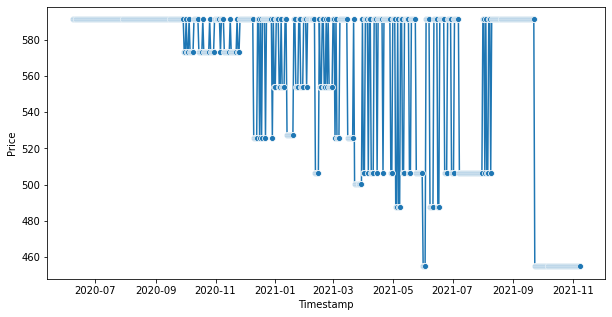

In [ ]:
product_id = [product_id_ord_fill[0]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")
plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o').set(xlabel='Timestamp', ylabel='Price')
if len(product_id) == 1:
  #ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))
#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

Dissertação/Chapters/Imagens/Chapter_Data/data_overview_timeSeriesExample3.


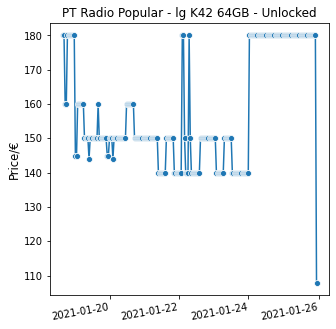

In [ ]:
# 1000  500  150
product_id = [product_id_ord_fill[150]]
#product_id = [1124]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

set_fig_size((5,5))
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o')
ax.set_xlabel("")
ax.set_ylabel("Price/€", fontsize = fontsize - 1.5)
ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0].capitalize())
ax.set_xticklabels(df_product.index.date, rotation = 10, ha = 'right')
xticks = ax.xaxis.get_major_ticks()
for i in range(0, len(xticks), 2):
  xticks[i].set_visible(False)

#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")
save_fig(plt, chapter_name = "Data", section_name = "overview", name_of_fig = "timeSeriesExample3")

In [ ]:
show_time_series(df_product, "product_id", info)

KeyError: ignored

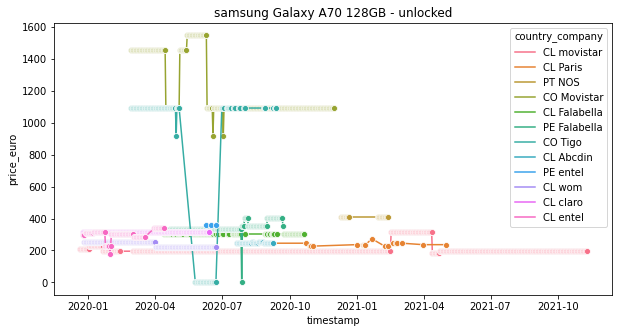

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

In [ ]:
#product_id = [product_id_ord_fill[800]]
product_id = 1124

df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

diff_order = 1
df_diff = diff_time_series_df(df_product, diff_order, columns = "price_euro")

# Difference
set_fig_size((5, 5))
sns_line = sns.lineplot(x = "timestamp", y = "price_euro", data = df_diff, marker = 'o')
sns_line.set_title("Differencing Order: " + str(diff_order))

TypeError: ignored

## Characteristics of the data

In [ ]:
df_changes_fill
df_changes_fill_ratio = df_changes_fill.copy()
df_changes_fill_ratio["ratio"] = df_changes_fill_ratio["n_changes"]/df_changes_fill_ratio["n_samples"]
df_changes_fill_ratio = df_changes_fill_ratio[df_changes_fill_ratio.n_samples > 10]
df_changes_fill_ratio.describe()

,n_changes,n_samples,ratio
count,2943.000000,2943.000000,2943.000000
mean,8.509004,248.098879,0.041141
std,11.608963,176.231813,0.042379
min,0.000000,11.000000,0.000000
25%,2.000000,105.000000,0.012712
50%,4.000000,228.000000,0.027094
75%,10.000000,335.000000,0.054878
max,103.000000,691.000000,0.352941


,n_changes,n_samples
count,3236.000000,3236.000000
mean,7.835909,225.921817
std,11.274815,182.172947
min,0.000000,1.000000
25%,1.000000,69.750000
50%,3.000000,193.500000
75%,9.000000,331.000000
max,103.000000,691.000000


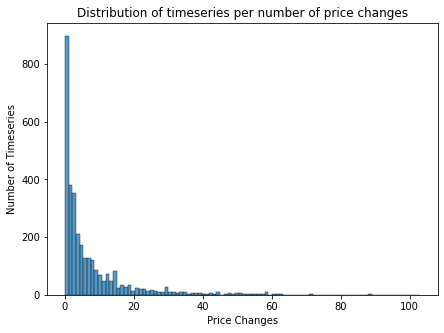

In [ ]:
set_fig_size((7, 5))
g = sns.histplot(data = df_changes_fill, x = "n_changes")
g.set(xlabel='Price Changes', ylabel='Number of Timeseries')
g.set_title("Distribution of timeseries per number of price changes")
#g.figure.savefig("Dissertação/Chapters/Imagens/data_n_changes.png")

df_changes_fill.describe()

Dissertação/Chapters/Imagens/Chapter_Data/data_overview_distributionNSamples.


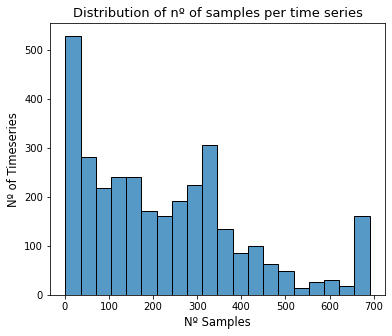

In [ ]:
set_fig_size((6, 5))
g = sns.histplot(data = df_changes_fill, x = "n_samples")
g.set_xlabel(xlabel='Nº Samples', fontsize = fontsize - 1.5)
g.set_ylabel(ylabel='Nº of Timeseries', fontsize = fontsize - 1.5)
g.set_title("Distribution of nº of samples per time series", fontsize = fontsize)
save_fig(plt, chapter_name = "Data", section_name = "overview", name_of_fig = "distributionNSamples")
#g.figure.savefig("Dissertação/Chapters/Imagens/data_n_samples.png")

Dissertação/Chapters/Imagens/Chapter_Data/data_overview_distributionPriceChangesPerDay.


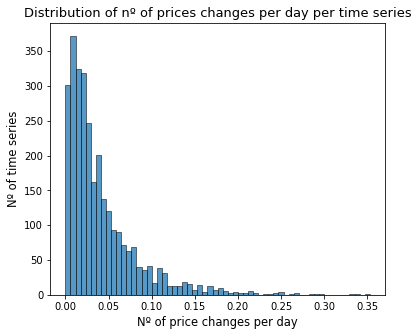

In [ ]:
g = sns.histplot(data = df_changes_fill_ratio.ratio)
g.set_xlabel('Nº of price changes per day', fontsize = fontsize - 1.5)
g.set_ylabel('Nº of time series', fontsize = fontsize - 1.5)
g.set_title("Distribution of nº of prices changes per day per time series", fontsize = fontsize)
#g.figure.savefig("Dissertação/Chapters/Imagens/data_ratio.png")
save_fig(plt, chapter_name = "Data", section_name = "overview", name_of_fig = "distributionPriceChangesPerDay")

## Temporal Patterns

##### Single timeseries

,price_euro,day_month
weekday,,
0,1,1
1,0,0
2,1,1
3,1,1
4,2,2
5,1,1
6,0,0


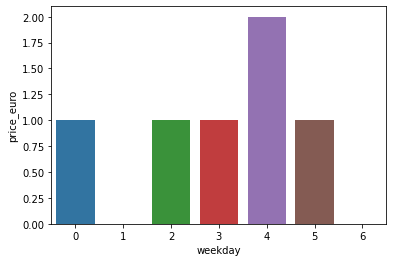

In [ ]:
product_id = [product_id_ord_fill[1000]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")
df_product = df_product.diff().dropna()
df_product["weekday"] = df_product.index.to_series().apply(datetime.weekday)
df_product["day_month"] = df_product.index.to_series().apply(lambda x : x.day)
df_product = df_product[df_product["price_euro"] != 0.0]
df_product = df_product.groupby(by = "weekday").count()
df_product = df_product.reindex(list(range(0, 7)),fill_value=0)
display(df_product)
sns.barplot(data = df_product, x = df_product.index, y = "price_euro")

##### Find patterns

In [ ]:
import datetime as dt

def prepare_df(df, id, value, time, interpolation_method):
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  return df

def count_changes_weekdays(df, id, value, time, interpolation_method):

  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df = df.groupby(id)[value].diff().dropna()
  df = df[df != 0]
  df = pd.DataFrame(df)
  
  df = df.reset_index()
  df["weekday"] = df["timestamp"].dt.dayofweek
  
  df = df.groupby(by = ["product_id", "weekday"]).size().unstack(level = -1).fillna(0).astype(int)
  df.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

  return df

def count_changes_weekdays_per_week(df, id, value, time, interpolation_method):

  #df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  #df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df = df.groupby(id)[value].diff().dropna()
  df = df[df != 0]
  df = pd.DataFrame(df)
  
  df = df.reset_index()
  df["weeknumber"] = df["timestamp"].dt.week
  df["year"] = df["timestamp"].dt.year
  df["weekday"] = df["timestamp"].dt.dayofweek
  
  df = df.groupby(by = ["product_id", "weeknumber", "year", "weekday"]).size().unstack(level = -1).fillna(0).astype(int)
  df.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

  return df

def count_changes_monthdays(df, id, value, time, interpolation_method):

  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df = df.groupby(id)[value].diff().dropna()
  df = df[df != 0]
  df = pd.DataFrame(df)
  
  df = df.reset_index()
  df["monthday"] = df["timestamp"].dt.day
  
  df = df.groupby(by = ["product_id", "monthday"]).size().unstack(level = -1).fillna(0).astype(int)
  #df.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

  return df

def count_changes_yearmonths(df, id, value, time, interpolation_method):

  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df = df.groupby(id)[value].diff().dropna()
  df = df[df != 0]
  df = pd.DataFrame(df)
  
  df = df.reset_index()
  print(type(df["timestamp"].loc[0]))
  df["yearday"] = df["timestamp"].dt.month
  df = df.groupby(by = ["product_id", "yearday"]).size().unstack(level = -1).fillna(0).astype(int)
  #df.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

  return df

def filter_number_observed_samples(row, min_num_samples = 5):
  if sum(row)/len(row) >= min_num_samples:
    return True
  else:
    return False

def normalize(row):
  return row/max(row)

def apply_ks(row, cdf):
  #row = normalize(np.cumsum(row))
  #row = normalize(row)
  return kstest(row, cdf)

def apply_distribution_test(df, min_num_samples, test, alpha = 0.05, test_args = {}):
  df = df[df.apply(filter_number_observed_samples, axis=1, **{"min_num_samples" : min_num_samples})]
  df = df.apply(test, axis = 1, **test_args)
  df = pd.DataFrame([[a, b] for a,b in df.values], columns=['stats', 'p']).set_index(df.index)
  df["null_hypothesis"] = df.p > alpha
  return df

Weeks

In [ ]:
print(len(df["product_id"].unique()))
print(len(df["company_id"].unique()))
print(len(df_ks))
print(len(df_ks_companies))

3236
27
118
25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, t

Text(0.5, 1.0, 'KS Companies')

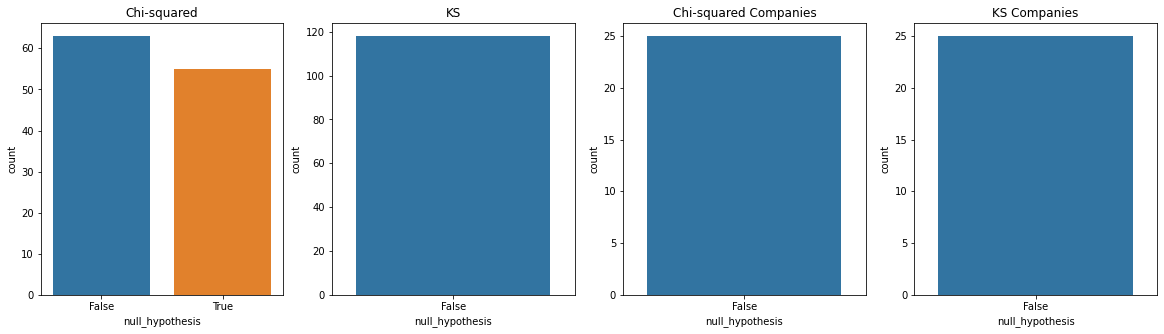

In [ ]:
# Get distribution of changes per weekday
df_weekdays = count_changes_weekdays(df, "product_id", "price_euro", "timestamp", "ffill")

# Get distribution of changes per weekday for companies
new_index = df[["product_id", "country_company"]].drop_duplicates().set_index("product_id")
df_weekdays_companies = pd.merge(df_weekdays, new_index, left_index=True, right_index=True).groupby(by = "country_company").sum()

# Apply chi square to individual timeseries
df_chi = apply_distribution_test(df_weekdays, min_num_samples = 5, test = chisquare, alpha = 0.05)
df_ks = apply_distribution_test(df_weekdays, min_num_samples = 5, test = apply_ks, alpha = 0.05, test_args = {"cdf" : "uniform"})
df_chi_companies = apply_distribution_test(df_weekdays_companies, min_num_samples = 5, test = chisquare, alpha = 0.05)
df_ks_companies = apply_distribution_test(df_weekdays_companies, min_num_samples = 5, test = apply_ks, alpha = 0.05, test_args = {"cdf" : "uniform"})

set_fig_size((20, 5))
fig, ax = plt.subplots(1,4)
sns.countplot(df_chi.null_hypothesis, ax=ax[0])
ax[0].set_title("Chi-squared")
sns.countplot(df_ks.null_hypothesis, ax=ax[1])
ax[1].set_title("KS")
sns.countplot(df_chi_companies.null_hypothesis, ax=ax[2])
ax[2].set_title("Chi-squared Companies")
sns.countplot(df_ks_companies.null_hypothesis, ax=ax[3])
ax[3].set_title("KS Companies")

Ks teste is really not valid for discrete distributions.

The timeseries that don't have an uniform distribution are the ones with the lowest number of samples, which may mean that the results of the test may not be completely fiable, and that is why there is variation in terms of considering if it's uniform or not.

Dissertação/Chapters/Imagens/Chapter_Data/data_temporalpatterns_chiSquareRejectNotReject.


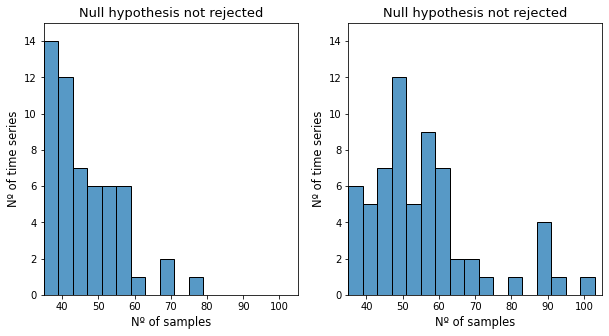

In [ ]:
index_lst_true = df_chi[df_chi["null_hypothesis"]].index
index_lst_false = df_chi[~df_chi["null_hypothesis"]].index
df_chi_true = df_weekdays.loc[index_lst_true].sum(axis = 1)
df_chi_false = df_weekdays.loc[index_lst_false].sum(axis = 1)

set_fig_size((10, 5))
fig, ax = plt.subplots(1,2)
p = sns.histplot(df_chi_true, binwidth = 4, ax = ax[0])
p.set_title("Null hypothesis not rejected", fontsize = fontsize)
p.set_xlabel(xlabel = "Nº of samples", fontsize = fontsize - 1.5)
p.set_ylabel(ylabel = "Nº of time series", fontsize = fontsize - 1.5)
p.set(xlim=(35, 105), ylim = (0, 15))

p = sns.histplot(df_chi_false, binwidth = 4, ax = ax[1])
p.set_title("Null hypothesis not rejected", fontsize = fontsize)
p.set_xlabel(xlabel = "Nº of samples", fontsize = fontsize - 1.5)
p.set_ylabel(ylabel = "Nº of time series", fontsize = fontsize - 1.5)
p.set(xlim=(35, 105), ylim = (0, 15))

#p.figure.savefig("Dissertação/Chapters/Imagens/explanation_chi_square_not_rejected.png")
save_fig(plt, chapter_name = "Data", section_name = "temporalPatterns", name_of_fig = "chiSquareRejectNotReject")

Dissertação/Chapters/Imagens/Chapter_Data/data_temporalpatterns_weekly_pattern_example_3.


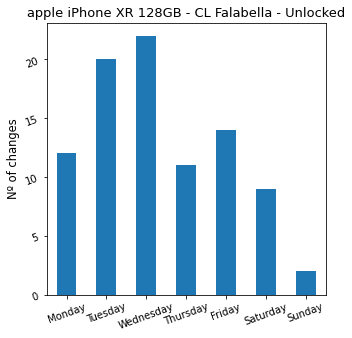

In [ ]:
product_id = product_id_ord_fill[2]
product_info = df[df["product_id"] == product_id].iloc[0]
title = product_info["product"] + " - " + product_info["country_company"] + " - " + product_info["offer_type"].capitalize()
set_fig_size((5,5))
p = df_weekdays.loc[product_id].plot.bar()
p.set_title(title, fontsize = fontsize)
p.set_ylabel(ylabel = "Nº of changes", fontsize = fontsize - 1.5)
p.tick_params(labelrotation=20)
#p.figure.savefig("Dissertação/Chapters/Imagens/weekly_pattern_example_1.png")
save_fig(plt, chapter_name = "Data", section_name = "temporalPatterns", name_of_fig = "weekly_pattern_example_3")

['CL' 'CO' 'PT' 'PE']


Index(['PT Radio Popular', 'PT Media Markt', 'PT MEO', 'PT Worten',
       'PT Vodafone', 'PT NOS'],
      dtype='object', name='country_company')

Dissertação/Chapters/Imagens/Chapter_Data/data_temporalpatterns_weeklyPatternPortugueseCompanies.


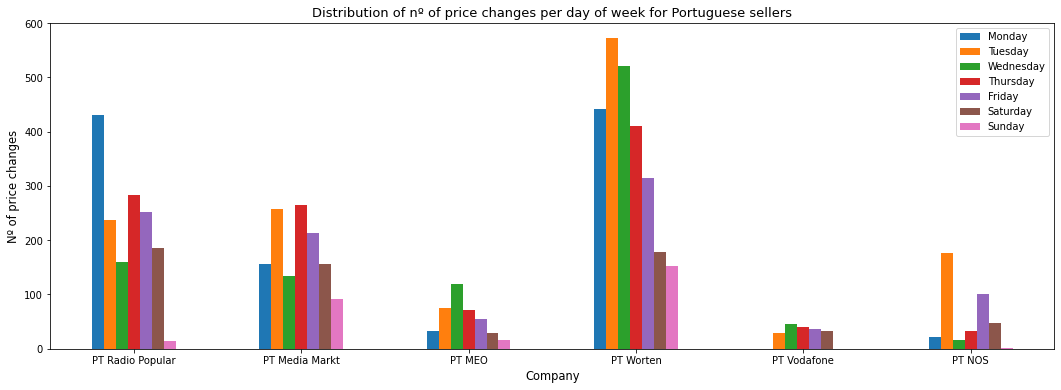

In [ ]:
new_index = df[["country", "country_company"]].drop_duplicates().set_index("country_company")
print(new_index.country.unique())
new_index = new_index[new_index.country == "PT"].index
display(new_index)
set_fig_size((18, 6))
p = df_weekdays_companies.loc[new_index].plot.bar()
p.set_ylabel(ylabel = "Nº of price changes", fontsize = fontsize - 1.5)
p.set_xlabel(xlabel = "Company", fontsize = fontsize - 1.5)
p.tick_params(labelrotation=0)
p.set_title("Distribution of nº of price changes per day of week for Portuguese sellers", fontsize = fontsize)
#p.figure.savefig("Dissertação/Chapters/Imagens/weekly_pattern_portuguese_companies.png")
save_fig(plt, chapter_name = "Data", section_name = "temporalPatterns", name_of_fig = "weeklyPatternPortugueseCompanies")

In [ ]:
df_prepared = prepare_df(df, "product_id", "price_euro", "timestamp", "ffill")
df_weekdays_week = count_changes_weekdays_per_week(df_prepared, "product_id", "price_euro", "timestamp", "ffill")
# Get distribution of changes per weekday for companies
new_index = df[["product_id", "company_id"]].drop_duplicates().set_index("product_id")
df_weekdays_week_companies = pd.merge(df_weekdays_week, new_index, left_index=True, right_index=True).groupby(by = ["company_id", "weeknumber", "year"]).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


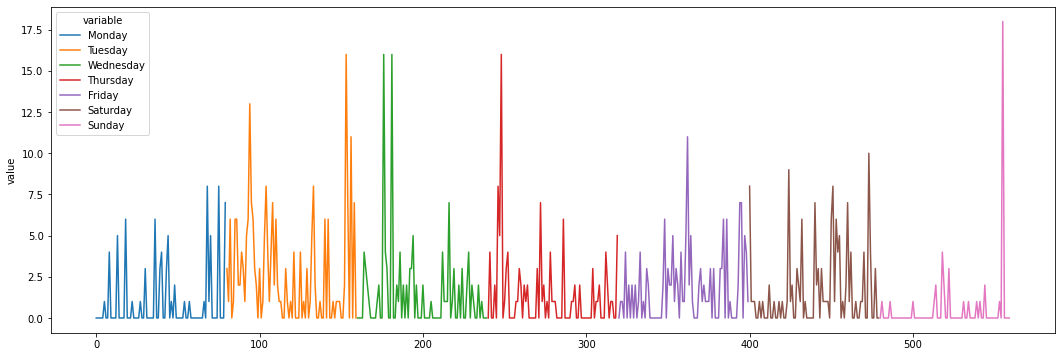

In [ ]:
def weeknumber_year_to_num(date):
  #print(date)
  weeknumber = date[0]
  year = date[1]
  #print((year-2019)*54 + weeknumber)
  return (year-2019)*54 + weeknumber

i = 12
a = pd.melt(df_weekdays_week_companies.loc[i].set_index(df_weekdays_week_companies.loc[i].index.map(lambda t: weeknumber_year_to_num(t))), ignore_index = False).reset_index()
#a = pd.melt(df_weekdays_week_companies.loc[i], ignore_index = False)
#display(a)
sns.lineplot(data = a, x = a.index, y = "value", hue = "variable")
set_fig_size((25, 15))
#sns.lineplot(data = a[a["variable"] == "Wednesday"], x = "index", hue = "variable", y = "value")

Months

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'KS Companies')

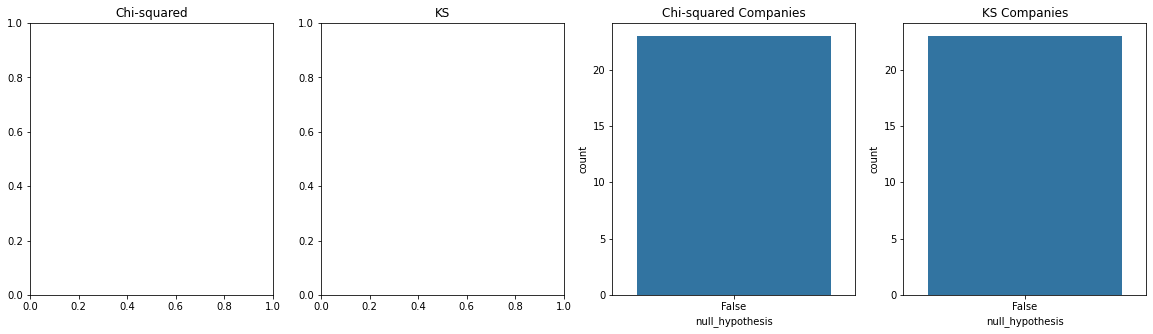

In [ ]:
# Get distribution of changes per weekday
df_monthdays = count_changes_monthdays(df, "product_id", "price_euro", "timestamp", "ffill")

# Get distribution of changes per weekday for companies
new_index = df[["product_id", "country_company"]].drop_duplicates().set_index("product_id")
df_monthdays_companies = pd.merge(df_monthdays, new_index, left_index=True, right_index=True).groupby(by = "country_company").sum()

# Apply chi square to individual timeseries and companies - there aren't enough samples to do a monthly analysis
#df_chi = apply_distribution_test(df_monthdays, min_num_samples = 5, test = chisquare, alpha = 0.05)
#df_ks = apply_distribution_test(df_monthdays, min_num_samples = 5, test = apply_ks, alpha = 0.05, test_args = {"cdf" : "uniform"})
df_chi_companies = apply_distribution_test(df_monthdays_companies, min_num_samples = 5, test = chisquare, alpha = 0.01)
df_ks_companies = apply_distribution_test(df_monthdays_companies, min_num_samples = 5, test = apply_ks, alpha = 0.01, test_args = {"cdf" : "uniform"})

set_fig_size((20, 5))
fig, ax = plt.subplots(1,4)
#sns.countplot(df_chi.null_hypothesis, ax=ax[0])
ax[0].set_title("Chi-squared")
#sns.countplot(df_ks.null_hypothesis, ax=ax[1])
ax[1].set_title("KS")
sns.countplot(df_chi_companies.null_hypothesis, ax=ax[2])
ax[2].set_title("Chi-squared Companies")
sns.countplot(df_ks_companies.null_hypothesis, ax=ax[3])
ax[3].set_title("KS Companies")

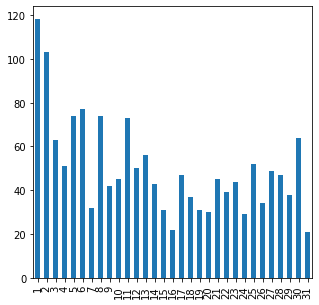

In [ ]:
set_fig_size((5,5))
index_lst_false = df_chi_companies[~df_chi_companies["null_hypothesis"]].index
index_lst_true = df_chi_companies[df_chi_companies["null_hypothesis"]].index
df_monthdays_companies.loc[index_lst_false[4]].plot.bar()

['CL' 'CO' 'PT' 'PE']
Dissertação/Chapters/Imagens/Chapter_Data/data_temporalpatterns_monthlyPatternPortugueseCompanies.


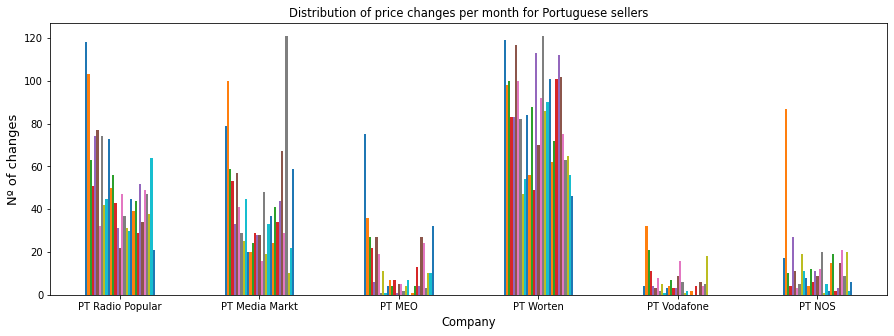

In [ ]:
new_index = df[["country", "country_company"]].drop_duplicates().set_index("country_company")
print(new_index.country.unique())
new_index = new_index[new_index.country == "PT"].index
set_fig_size((15, 5))
p = df_monthdays_companies.loc[new_index].plot.bar()
p.set_ylabel(ylabel = "Nº of changes", fontsize = fontsize)
p.set_xlabel(xlabel = "Company", fontsize = fontsize - 1.5)
p.tick_params(labelrotation=0)
p.set_title("Distribution of price changes per month for Portuguese sellers", fontsize = fontsize - 1.5)
#p.legend(loc=5)
p.get_legend().remove()
#p.figure.savefig("Dissertação/Chapters/Imagens/monthly_pattern_portuguese_companies.png")
save_fig(plt, chapter_name = "Data", section_name = "temporalPatterns", name_of_fig = "monthlyPatternPortugueseCompanies")

Yearly

There wasn't enough information to perform an analysis per day of year. So instead I did an analysis per month, to see if there are particular months in which the companies are more active than others.

In [ ]:
# Get distribution of changes per weekday
df_yeardays = count_changes_yearmonths(df, "product_id", "price_euro", "timestamp", "ffill")

# Get distribution of changes per weekday for companies
new_index = df[["product_id", "country_company"]].drop_duplicates().set_index("product_id")
df_yeardays_companies = pd.merge(df_yeardays, new_index, left_index=True, right_index=True).groupby(by = "country_company").sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
# Apply chi square to individual timeseries and companies - there aren't enough samples to do a monthly analysis
#df_chi = apply_distribution_test(df_monthdays, min_num_samples = 5, test = chisquare, alpha = 0.05)
#df_ks = apply_distribution_test(df_monthdays, min_num_samples = 5, test = apply_ks, alpha = 0.05, test_args = {"cdf" : "uniform"})
df_chi_companies = apply_distribution_test(df_yeardays_companies, min_num_samples = 5, test = chisquare, alpha = 0.05)
df_ks_companies = apply_distribution_test(df_yeardays_companies, min_num_samples = 5, test = apply_ks, alpha = 0.05, test_args = {"cdf" : "uniform"})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'KS Companies')

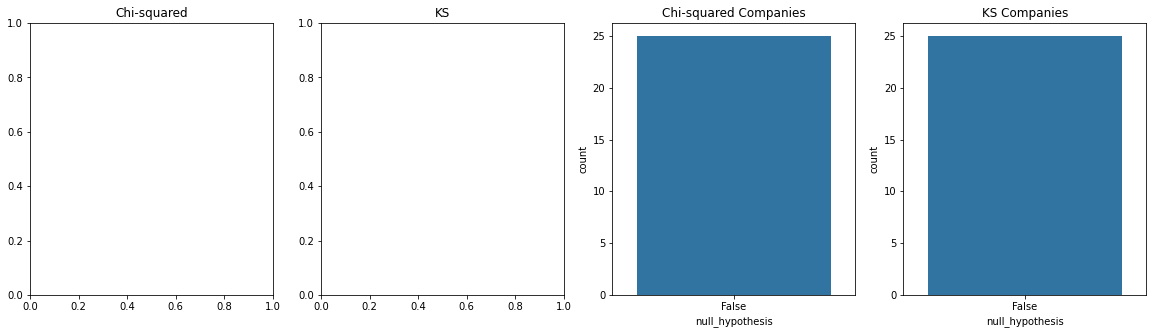

In [ ]:
set_fig_size((20, 5))
fig, ax = plt.subplots(1,4)
#sns.countplot(df_chi.null_hypothesis, ax=ax[0])
ax[0].set_title("Chi-squared")
#sns.countplot(df_ks.null_hypothesis, ax=ax[1])
ax[1].set_title("KS")
sns.countplot(df_chi_companies.null_hypothesis, ax=ax[2])
ax[2].set_title("Chi-squared Companies")
sns.countplot(df_ks_companies.null_hypothesis, ax=ax[3])
ax[3].set_title("KS Companies")

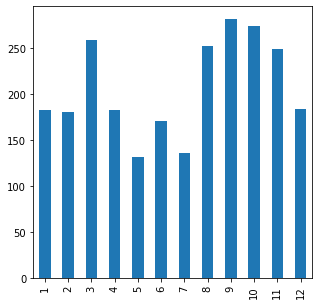

In [ ]:
set_fig_size((5,5))
index_lst_false = df_chi_companies[~df_chi_companies["null_hypothesis"]].index
index_lst_true = df_chi_companies[df_chi_companies["null_hypothesis"]].index
df_yeardays_companies.loc[index_lst_false[3]].plot.bar()

['CL' 'CO' 'PT' 'PE']
Dissertação/Chapters/Imagens/Chapter_Data/data_temporalpatterns_yearlyPatternPortugueseCompanies.


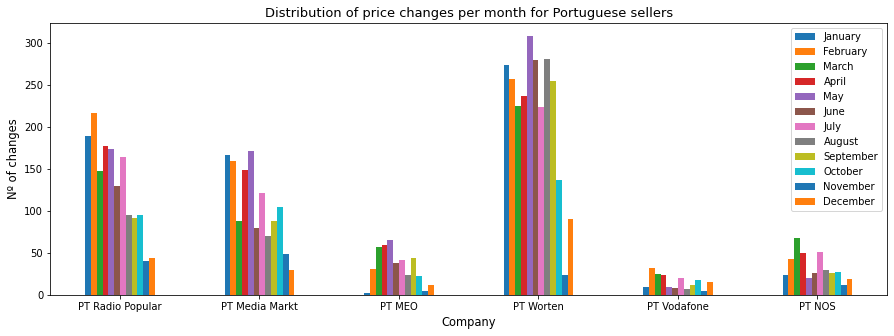

In [ ]:
new_index = df[["country", "country_company"]].drop_duplicates().set_index("country_company")
print(new_index.country.unique())
new_index = new_index[new_index.country == "PT"].index
set_fig_size((15, 5))
p = df_yeardays_companies.loc[new_index].plot.bar()
p.set_ylabel(ylabel = "Nº of changes", fontsize = fontsize-1.5)
p.set_xlabel(xlabel = "Company", fontsize = fontsize-1.5)
p.tick_params(labelrotation=0)
p.set_title("Distribution of price changes per month for Portuguese sellers", fontsize=fontsize)
p.legend(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], loc="upper right", fontsize = 10)
#p.figure.savefig("Dissertação/Chapters/Imagens/yearly_pattern_portuguese_companies.png")
save_fig(plt, chapter_name = "Data", section_name = "temporalPatterns", name_of_fig = "yearlyPatternPortugueseCompanies")

##### All timeseries

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

df_weekdays = df.copy()
df_weekdays = df_weekdays[[id, value, time]].sort_values([id, time])                         
df_weekdays = df_weekdays.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
df_weekdays["changes"] = df_weekdays.groupby(id)[value].diff()
df_weekdays = df_weekdays.dropna()
df_weekdays["weekday"] = df_weekdays.reset_index().timestamp.apply(datetime.weekday).to_numpy()
df_weekdays["day_month"] = df_weekdays.reset_index().timestamp.apply(lambda x : x.day).to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


KeyboardInterrupt: ignored

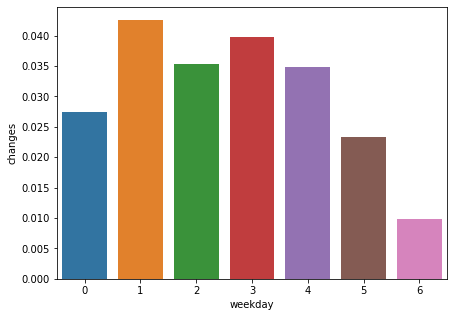

In [ ]:
df_weekdays["changes"] = df_weekdays["changes"] != 0
df_weekdays_count = df_weekdays.groupby(by = "weekday").mean()
sns.barplot(data = df_weekdays_count, x = df_weekdays_count.index, y = "changes")

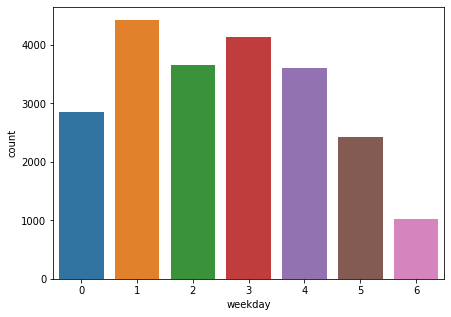

In [ ]:
df_weekdays_count = df_weekdays[df_weekdays["changes"] != 0.0]
sns.countplot(data = df_weekdays_count, x = "weekday")

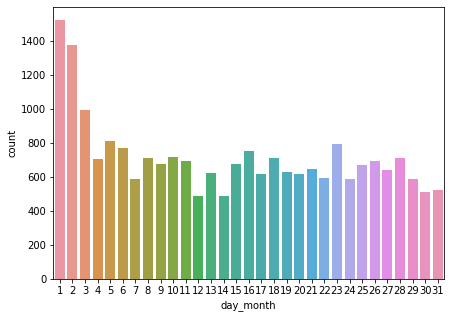

In [ ]:
set_fig_size((7, 5))
sns.countplot(data = df_weekdays_count, x = "day_month")

##### Types of changes per day of week

In [ ]:
def convert_2_states(data):
    value = data.columns[0]
    data_states = data.copy()
    data_states["diff"] = data.diff()
    data_states["states"] = data.diff()
    data_states.loc[data_states["diff"] < 0, "states"] = 0
    data_states.loc[data_states["diff"] == 0, "states"] = 1
    data_states.loc[data_states["diff"] > 0, "states"] = 2
    data_states = data_states.drop([value, "diff"], axis = 1)
    return data_states

def get_transitions_matrix(states, n_states = 3):
  states = states.copy()
  states["previous_states"] = states.shift(periods = 1)
  transitions = states.apply(transition_positions, axis = 1, **{"previous_state" : "previous_states", "current_state" : "states", "n_states" : n_states})
  transition_matrix = transitions.value_counts().reindex(index=range(0, n_states**2), fill_value=0)
  transition_matrix = np.array(transition_matrix).reshape(-1, n_states)
  row_sums = transition_matrix.sum(axis=1)
  transition_matrix = transition_matrix/row_sums[:,np.newaxis]
  return transition_matrix
    
def fit(data):
  data = data
  obs = convert_2_states(data)
  transition_matrix = get_transitions_matrix(obs)


id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

df_inter = df[df["product_id"].isin([284])]
df_inter = df[[id, value, time]].sort_values([id, time])                         
df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})

results2 = df_inter.groupby(id).apply(convert_2_states)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
results = results2.reset_index()
results["timestamp"] = results["timestamp"].apply(datetime.weekday)
results = results.set_index("product_id")
results

,timestamp,states
product_id,,
1,1,NaN
1,2,1.0
1,3,1.0
1,4,1.0
1,5,1.0
...,...,...
3236,4,1.0
3236,5,1.0
3236,6,1.0


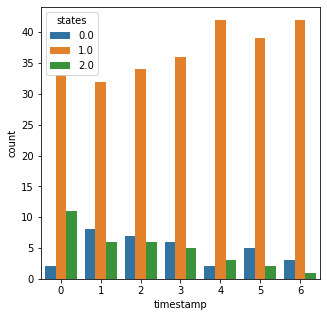

In [ ]:
sns.countplot(data = results.loc[product_id_ord_fill[12]], x = "timestamp", hue = "states")

## Missing values - Specific Models

In [ ]:
def crash():
    0/0

def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

def prepare_df(df, id, value, time, interpolation_method):
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  return df

def find_local_max(df):
  df['max'] = ((df.days_out_of_stock.shift(1) < df.days_out_of_stock) & (df.days_out_of_stock.shift(-1) < df.days_out_of_stock))
  return df

def convert_2_states_w_na(data, value = "price_euro"):
  value = data.columns[0]
  data_states = data.copy()
  data_states["diff"] = data[value].diff()
  data_states["states"] = data[value].diff()
  data_states.loc[data_states["diff"] < 0, "states"] = 0
  data_states.loc[data_states["diff"] == 0, "states"] = 1
  data_states.loc[data_states["diff"] > 0, "states"] = 2
  data_states.loc[data_states["out_of_stock"] == 1, "states"] = 3
  return data_states

def study_missing_values(df, n_past_days):                               
  df = df.groupby("product_id").apply(convert_2_states_w_na).groupby("product_id").apply(find_local_max)        # add states and diff columns
  df = df.join(df.groupby("product_id").apply(lambda df : series_to_supervised(df["price_euro"], n_in = n_past_days, n_out = 1, dropnan = False)).set_index(df.index), rsuffix = "_price_euro") # convert column of time into row
  df = df.join(df.groupby("product_id").apply(lambda df : series_to_supervised(df["diff"]      , n_in = n_past_days, n_out = 1, dropnan = False)).set_index(df.index), rsuffix = "_diff")       # convert column of time into row
  df = df.join(df.groupby("product_id").apply(lambda df : series_to_supervised(df["states"]    , n_in = n_past_days, n_out = 1, dropnan = False)).set_index(df.index), rsuffix = "_states")     # convert column of time into row

  df = df[df["states"] == 3]                                                                    # select only the days when a missing value ocurred
  df = df[(df["days_out_of_stock"] == 1) | df["max"]]                                           # select the first and last days of missing values
  df["days_out_of_stock_2"] = df["days_out_of_stock"].shift(-1, fill_value = 1)                 # shift so that the information associated with how long a missing value period lasted is saved 
  df = df[(df["days_out_of_stock_2"] != 1) | (df["days_out_of_stock"] == 1 & df["max"])]   # keep the columns of just the days of the beginning of the missing values
  df["days_out_of_stock"] = df["days_out_of_stock_2"]                                           # erase auxiliary column
  df = df.drop("days_out_of_stock_2", axis = 1)                                                 # erase auxiliary column

  features = [f"var1(t-{i})_states" for i in range(1, n_past_days+1)]
  counts = ["down_count", "up_count", "missing_count", "changes_count"]
  df["down_count"]    = df[features].apply(lambda x: sum(x==0), axis=1)
  df["same_count"]    = df[features].apply(lambda x: sum(x==1), axis=1)
  df["up_count"]      = df[features].apply(lambda x: sum(x==2), axis=1)
  df["missing_count"] = df[features].apply(lambda x: sum(x==3), axis=1)
  df["changes_count"] = df[features].apply(lambda x: sum(x==0) + sum(x==2), axis=1)

  return df

def process_study_values(df_mv, df):
  df_mv_2 = df_mv.groupby("product_id")[["down_count","same_count","up_count","missing_count","changes_count"]].count()
  df_mv_2[["down_mean","same_mean", "up_mean","missing_mean","changes_mean"]] = df_mv.groupby("product_id")[["down_count","same_count","up_count","missing_count","changes_count"]].mean()
  df_mv_2["n_miss_vals"] = df_mv.groupby("product_id")[["down_count","same_count","up_count","missing_count","changes_count"]].size()

  new_index = df[["product_id", "product", "country_company", "country"]].set_index("product_id").drop_duplicates()
  df_mv_2 = df_mv_2.join(new_index, how = "inner")

  return df_mv_2


def study_ref_values(df, n_past_days):
  
  df = df.groupby("product_id").apply(convert_2_states_w_na)
  df = df.join(df.groupby("product_id").apply(lambda df : series_to_supervised(df["price_euro"], n_in = n_past_days, n_out = 1, dropnan = False)).set_index(df.index), rsuffix = "_price_euro") # convert column of time into row
  df = df.join(df.groupby("product_id").apply(lambda df : series_to_supervised(df["diff"]      , n_in = n_past_days, n_out = 1, dropnan = False)).set_index(df.index), rsuffix = "_diff")       # convert column of time into row
  df = df.join(df.groupby("product_id").apply(lambda df : series_to_supervised(df["states"]    , n_in = n_past_days, n_out = 1, dropnan = False)).set_index(df.index), rsuffix = "_states")     # convert column of time into row

  features = [f"var1(t-{i})_states" for i in range(1, n_past_days+1)]
  counts = ["down_count", "up_count", "missing_count", "changes_count"]
  df["down_count"]    = df[features].apply(lambda x: sum(x==0), axis=1)
  df["same_count"]    = df[features].apply(lambda x: sum(x==1), axis=1)
  df["up_count"]      = df[features].apply(lambda x: sum(x==2), axis=1)
  df["missing_count"] = df[features].apply(lambda x: sum(x==3), axis=1)
  df["changes_count"] = df[features].apply(lambda x: sum(x==0) + sum(x==2), axis=1)

  return df

In [ ]:
n_past_days = 7
#new_index = df[["product_id", "product", "country_company", "country"]].set_index("product_id").drop_duplicates()

#df_prepared = prepare_df(df.copy(), "product_id", "price_euro", "timestamp", "ffill")
#df_prepared.to_pickle("df_prepared")
df_prepared = pd.read_pickle("df_prepared")

#df_mv = study_missing_values(df_prepared, n_past_days)
#df_mv = df_mv.join(new_index, how = "inner")
#df_mv.to_pickle("df_mv")
df_mv = pd.read_pickle("df_mv")
df_mv_2 = process_study_values(df_mv, df)

#df_ref = study_ref_values(df_prepared, n_past_days)
#df_ref = df_ref.join(new_index, how = "inner")
#df_ref.to_pickle("df_ref")
df_ref = pd.read_pickle("df_ref")
df_ref_2 = process_study_values(df_ref, df)

In [ ]:
n_past_days = 14
new_index = df[["product_id", "product", "country_company", "country"]].set_index("product_id").drop_duplicates()

#df_prepared = prepare_df(df.copy(), "product_id", "price_euro", "timestamp", "ffill")
#df_prepared.to_pickle("df_prepared_14")
df_prepared = pd.read_pickle("df_prepared")

#df_mv = study_missing_values(df_prepared, n_past_days)
#df_mv = df_mv.join(new_index, how = "inner")
#df_mv.to_pickle("df_mv_14")
df_mv = pd.read_pickle("df_mv")
df_mv_2 = process_study_values(df_mv, df)

df_ref = study_ref_values(df_prepared, n_past_days)
df_ref = df_ref.join(new_index, how = "inner")
df_ref.to_pickle("df_ref_14")
#df_ref = pd.read_pickle("df_ref")
df_ref_2 = process_study_values(df_ref, df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


##### Univariate approach

In the univariate approach we use only information on the series itself to predict how many days the missing values will remain.

However, missing values are not abundant per timeseries. Assuming we want to predict three types of duration of missing values (just one day, between 2 days and 7 days and more than 7 days for instance) using at least three variables (up_count, down_count, missing_count), how many samples are needed? Let's assume in the worst case, five samples per class. That would be 15 samples, that is, a timeseries should have at least 15 instances of missing values for us to be able to make a confident prediction using just the information contained in the series itself.

In [ ]:
df_mv_2.columns

Index(['down_count', 'same_count', 'up_count', 'missing_count',
       'changes_count', 'down_mean', 'same_mean', 'up_mean', 'missing_mean',
       'changes_mean', 'n_miss_vals', 'product', 'country_company', 'country'],
      dtype='object')

10

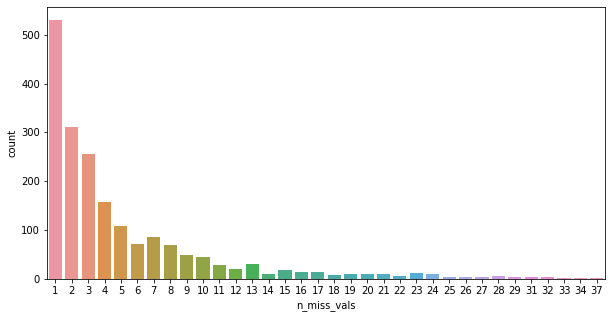

In [ ]:
set_fig_size((10, 5))
sns.countplot(data = df_mv_2, x = "n_miss_vals")
len(df_mv_2[df_mv_2["n_miss_vals"] >30])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


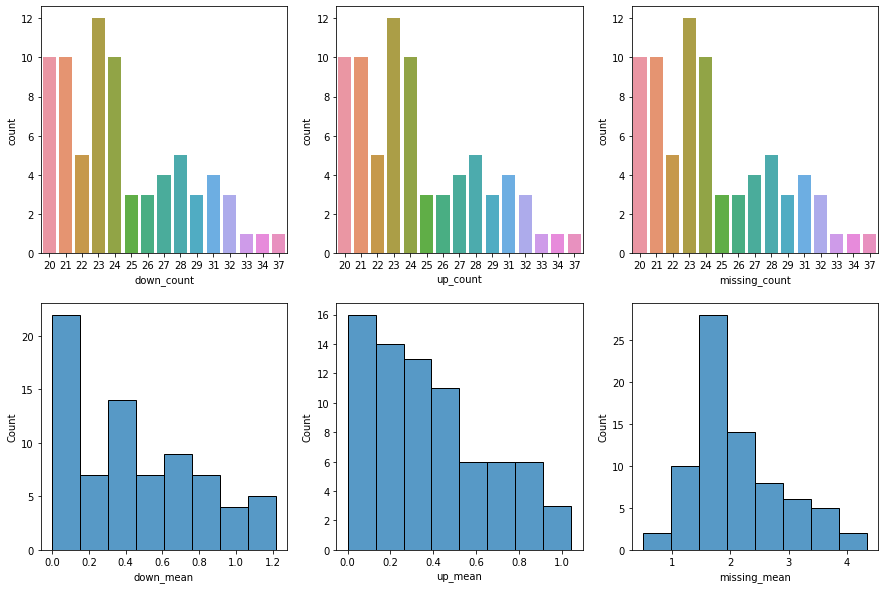

In [ ]:
n_miss_vals = 20
df_flt = df_mv_2[df_mv_2["n_miss_vals"] >= n_miss_vals]

set_fig_size((15, 10))
fig, ax = plt.subplots(2,3)

p = sns.countplot(df_flt["down_count"], ax = ax[0,0])
#p.set_xlim(0, 3)
#p.set_ylim(1, 1300)
p = sns.countplot(df_flt["up_count"], ax = ax[0,1])
#p.set_xlim(0, 3)
#p.set_ylim(1, 1300)
p = sns.countplot(df_flt["missing_count"], ax = ax[0,2])
#p.set_xlim(0, 3)
#p.set_ylim(1, 1300)
p = sns.histplot(df_flt["down_mean"], ax = ax[1,0])
#p.set_xlim(0, 5)
#p.set_ylim(1, 1300)
p = sns.histplot(df_flt["up_mean"], ax = ax[1,1])
#p.set_xlim(0, 5)
#p.set_ylim(1, 1300)
p = sns.histplot(df_flt["missing_mean"], ax = ax[1,2])
#p.set_xlim(0, 5)
#p.set_ylim(1, 1300)

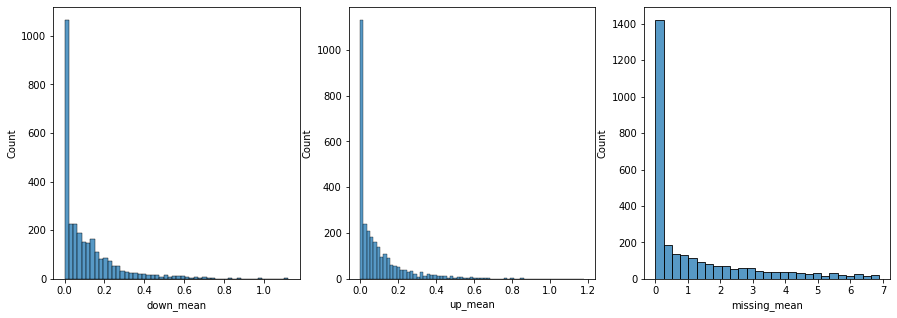

In [ ]:
set_fig_size((15, 5))
fig, ax = plt.subplots(1,3)

p = sns.histplot(data = df_ref_2["down_mean"], ax = ax[0])
#p.set_xlim(0, 5)
#p.set_ylim(1, 1300)
p = sns.histplot(data = df_ref_2["up_mean"], ax = ax[1])
#p.set_xlim(0, 5)
#p.set_ylim(1, 1300)
p = sns.histplot(data = df_ref_2["missing_mean"], ax = ax[2])
#p.set_xlim(0, 5)
#p.set_ylim(1, 1300)

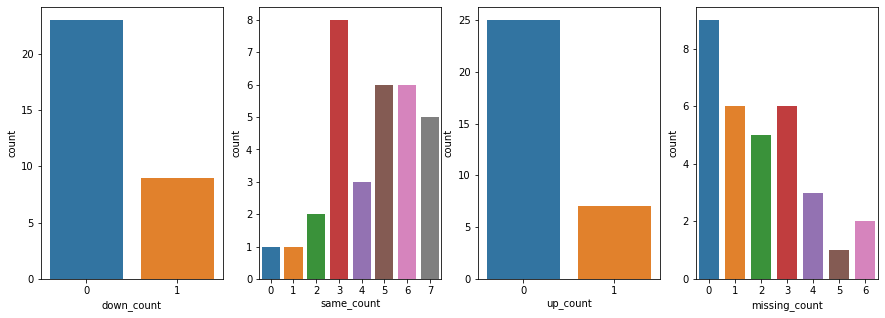

In [ ]:
n_miss_vals = 30
product_id = 0
df_series = df_mv.loc[df_mv_2[df_mv_2["n_miss_vals"] >= n_miss_vals].index]
lst = df_series.index.get_level_values(0)
df_series = df_series.loc[lst[product_id]]

set_fig_size((15, 5))
fig, ax = plt.subplots(1,4)

p = sns.countplot(data = df_series, x = "down_count", ax = ax[0])
p = sns.countplot(data = df_series, x = "same_count", ax = ax[1])
p = sns.countplot(data = df_series, x = "up_count", ax = ax[2])
p = sns.countplot(data = df_series, x = "missing_count", ax = ax[3])

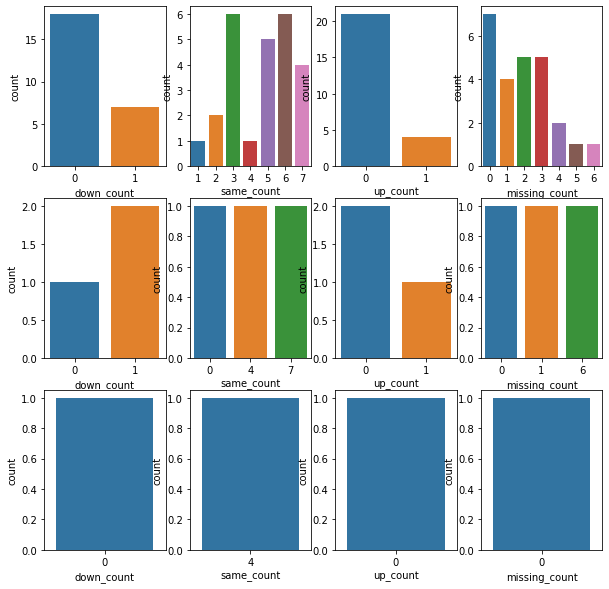

In [ ]:
set_fig_size((10, 10))
fig, ax = plt.subplots(3,4)

#a = df_series.copy()
df_mv_int_1 = df_series[df_series["days_out_of_stock"] < 3]
df_mv_int_2 = df_series[(df_series["days_out_of_stock"] > 3) & (df_series["days_out_of_stock"] < 7)]
df_mv_int_3 = df_series[df_series["days_out_of_stock"] > 7]

p = sns.countplot(data = df_mv_int_1, x = "down_count", ax = ax[0,0])
p = sns.countplot(data = df_mv_int_1, x = "same_count", ax = ax[0,1])
p = sns.countplot(data = df_mv_int_1, x = "up_count", ax = ax[0,2])
p = sns.countplot(data = df_mv_int_1, x = "missing_count", ax = ax[0,3])
p = sns.countplot(data = df_mv_int_2, x = "down_count", ax = ax[1,0])
p = sns.countplot(data = df_mv_int_2, x = "same_count", ax = ax[1,1])
p = sns.countplot(data = df_mv_int_2, x = "up_count", ax = ax[1,2])
p = sns.countplot(data = df_mv_int_2, x = "missing_count", ax = ax[1,3])
p = sns.countplot(data = df_mv_int_3, x = "down_count", ax = ax[2,0])
p = sns.countplot(data = df_mv_int_3, x = "same_count", ax = ax[2,1])
p = sns.countplot(data = df_mv_int_3, x = "up_count", ax = ax[2,2])
p = sns.countplot(data = df_mv_int_3, x = "missing_count", ax = ax[2,3])

In [ ]:
df_mv_2.columns

Index(['down_count', 'same_count', 'up_count', 'missing_count',
       'changes_count', 'down_mean', 'same_mean', 'up_mean', 'missing_mean',
       'changes_mean', 'n_miss_vals', 'product', 'country_company', 'country'],
      dtype='object')

##### Multivariate apporach

Let's start by assuming that a company usually uses the same method for treating missing values per product (try to prove this - see if different companies have different signatures, see if different products have similar distributions - try to train a model) - try to predict missing values of company regardless of the product.

This way the information that we discarded from all the products that didn't have enough missing values are considered.

In [ ]:
countries_lst = df_mv.country.unique()

In [ ]:
country = 0
print(countries_lst[country])
n_miss_vals = 15
#n_miss_days = 1

df_country = df_mv[df_mv["country"] == countries_lst[country]]
df_country_2 = df_mv_2[df_mv_2["country"] == countries_lst[country]]
df_country_ref = df_ref[df_ref["country"] == countries_lst[country]]
df_country_2_ref = df_ref_2[df_ref_2["country"] == countries_lst[country]]

CL


In [ ]:
df_country

In [ ]:
index = df_country_2.sort_values(by = "n_miss_vals", ascending = False).iloc[:5].index
n_past_days = 7

set_fig_size((20, 20))
fig, ax = plt.subplots(len(index),4, sharex = False)

features = [f"var1(t-{i})_states" for i in range(1, n_past_days+1)]

for product_id, i in zip(index, range(len(index))):

  sns.countplot(data = df_country.loc[product_id], x = "down_count", ax = ax[i,0])
  sns.countplot(data = df_country.loc[product_id], x = "same_count", ax = ax[i,1])
  sns.countplot(data = df_country.loc[product_id], x = "up_count", ax = ax[i,2])
  sns.countplot(data = df_country.loc[product_id], x = "missing_count", ax = ax[i,3])

In [ ]:
index = df_country_2.sort_values(by = "n_miss_vals", ascending = False).iloc[:5].index
n_past_days = 7

set_fig_size((20, 20))
fig, ax = plt.subplots(len(index),n_past_days, sharex = False)

features = [f"var1(t-{i})_states" for i in range(1, n_past_days+1)]

for product_id, i in zip(index, range(len(index))):

  for feature, j in zip(features, range(len(features))):
    p = sns.countplot(data = df_country.loc[product_id], x = feature, ax = ax[i,j])
    p.set(xticks=range(4), xticklabels=[0, 1, 2, 3])

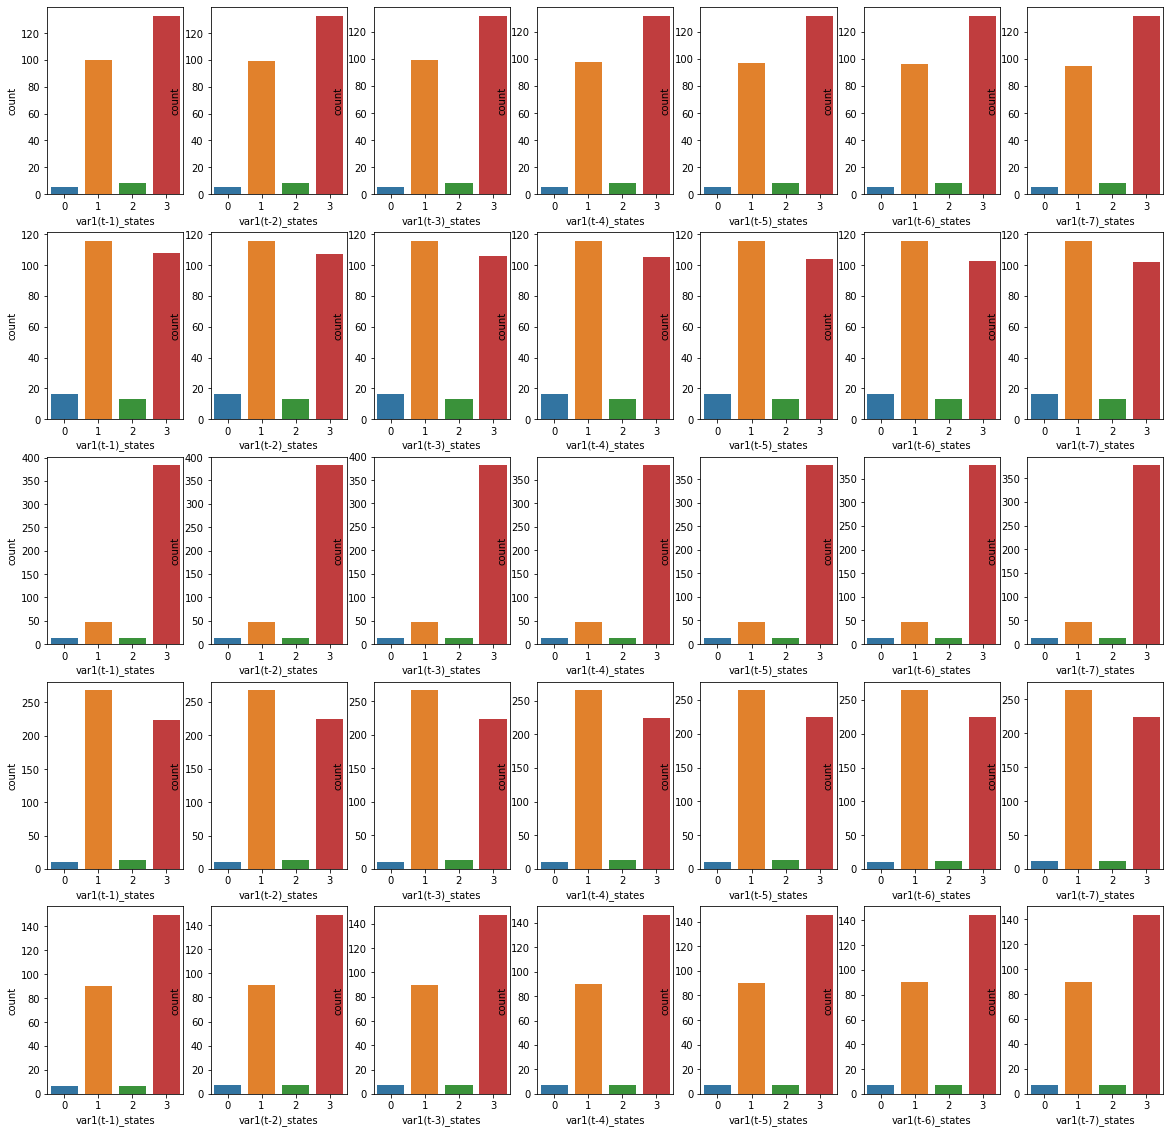

In [ ]:
index = df_country_2.sort_values(by = "n_miss_vals", ascending = False).iloc[:5].index
n_past_days = 7

set_fig_size((20, 20))
fig, ax = plt.subplots(len(index),n_past_days, sharex = False)

features = [f"var1(t-{i})_states" for i in range(1, n_past_days+1)]

for product_id, i in zip(index, range(len(index))):

  for feature, j in zip(features, range(len(features))):
    p = sns.countplot(data = df_ref.loc[product_id], x = feature, ax = ax[i,j])
    p.set(xticks=range(4), xticklabels=[0, 1, 2, 3])

###### Predict if a missig value will appear

In [ ]:
country = 0
countries_lst = df_mv.country.unique()
print(countries_lst[country])

n_miss_vals = 15
#n_miss_days = 1

df_country = df_mv[df_mv["country"] == countries_lst[country]]
df_country_2 = df_mv_2[df_mv_2["country"] == countries_lst[country]]
df_country_ref = df_ref[df_ref["country"] == countries_lst[country]]
df_country_2_ref = df_ref_2[df_ref_2["country"] == countries_lst[country]]

CL


In [ ]:
apagar as linhas em que os missing values já não estão no primeiro dia, para isso há outros modelos que estão a ser treinados, mas tentar da primeira vez asssim
tentar com mais do que 7 dias, já que temos tantos exemplos
ver se as classes estão desbalanceadas

In [ ]:
df_pred_mv = df_country_ref.dropna()
df_pred_mv["states_binary"] = (df_pred_mv["states"] == 3).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_pred_mv

price_euro  days_out_of_stock  out_of_stock  diff  \
product_id timestamp                                                       
1          2020-04-22  727.726735                  0             0   0.0   
           2020-04-23  727.726735                  0             0   0.0   
           2020-04-24  727.726735                  0             0   0.0   
           2020-04-25  727.726735                  0             0   0.0   
           2020-04-26  727.726735                  0             0   0.0   
...                           ...                ...           ...   ...   
3230       2021-03-18  209.214955                  0             0   0.0   
           2021-03-19  209.214955                  0             0   0.0   
           2021-03-20  209.214955                  0             0   0.0   
           2021-03-21  209.214955                  0             0   0.0   
           2021-03-22  209.214955                  0             0   0.0   

                       states   var1(t-7)   var1(t-6)   var1(t-5)   var1(t-4)  \
product_id timestamp                                                            
1          2020-04-22     1.0  727.726735  727.726735  727.726735  727.726735   
           2020-04-23     1.0  727.726735  727.726735  727.726735  727.726735   
           2020-04-24     1.0  727.726735  727.726735  727.726735  727.726735   
           2020-04-25     1.0  727.726735  727.726735  727.726735  727.726735   
           2020-04-26     1.0  727.726735  727.726735  727.726735  727.726735   
...                       ...         ...         ...         ...         ...   
3230       2021-03-18     1.0  209.214955  209.214955  209.214955  209.214955   
           2021-03-19     1.0  209.214955  209.214955  209.214955  209.214955   
           2021-03-20     1.0  209.214955  209.214955  209.214955  209.214955   
           2021-03-21     1.0  209.214955  209.214955  209.214955  209.214955   
           2021-03-22     1.0  209.214955  209.214955  209.214955  209.214955   

                        var1(t-3)  ...  var1(t)_states  down_count  \
product_id timestamp               ...                               
1          2020-04-22  727.726735  ...             1.0           0   
           2020-04-23  727.726735  ...             1.0           0   
           2020-04-24  727.726735  ...             1.0           0   
           2020-04-25  727.726735  ...             1.0           0   
           2020-04-26  727.726735  ...             1.0           0   
...                           ...  ...             ...         ...   
3230       2021-03-18  209.214955  ...             1.0           0   
           2021-03-19  209.214955  ...             1.0           0   
           2021-03-20  209.214955  ...             1.0           0   
           2021-03-21  209.214955  ...             1.0           0   
           2021-03-22  209.214955  ...             1.0           0   

                       same_count  up_count  missing_count  changes_count  \
product_id timestamp                                                        
1          2020-04-22           7         0              0              0   
           2020-04-23           7         0              0              0   
           2020-04-24           7         0              0              0   
           2020-04-25           7         0              0              0   
           2020-04-26           7         0              0              0   
...                           ...       ...            ...            ...   
3230       2021-03-18           7         0              0              0   
           2021-03-19           7         0              0              0   
           2021-03-20           7         0              0              0   
           2021-03-21           7         0              0              0   
           2021-03-22           7         0              0              0   

                                      product  country_company  cou

## Dimensionality Reduction

In [ ]:
def plot_dim_reduction(X, y, ax = None, title = "LDA", xlim = None):
  if X.shape[1] > 1:
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1)
  else:
    filler = [random.randint(0,10000) for i in range(len(y))]
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(filler), pd.DataFrame(y.reset_index(drop = True))], axis = 1, ignore_index = True)
    
  data.columns = ["feat1", "feat2", "class"]
  data["class"] = data["class"].astype("category")
  h = sns.scatterplot(data = data, x = "feat1", y = "feat2", hue = "class", ax = ax, alpha = 0.01)
  h.set_title(title)
  h.set(xlim = xlim)

  return h

In [ ]:
product_id = product_id_ord_fill[0]
lags_list = [7, 14, 21]
data_lags = []

for lags in lags_list:
  X_group, y_group = read_df_lags(lags, product_id)
  y_group = [y_group[1]]*3 + [y_group[4]]*3
  data_lags.append([X_group, y_group])

##### PCA

array([0.46413725, 0.11685922])

array([0.14475701, 0.12899358])

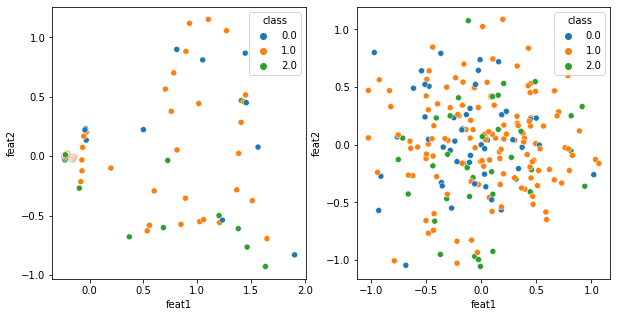

In [ ]:
n_components = 2
pipe_pca = make_pipeline(MinMaxScaler(), PCA(n_components=n_components))   
X_pca = pipe_pca.fit(X).transform(X)
display(pipe_pca[1].explained_variance_ratio_)
X_pca_class = pipe_pca.fit(X_class).transform(X_class)
display(pipe_pca[1].explained_variance_ratio_)

set_fig_size((10, 5))
fig, ax = plt.subplots(1,2)
plot_dim_reduction(X_pca, y_class, ax = ax[0])
plot_dim_reduction(X_pca_class, y_class, ax = ax[1])

array([0.14833948, 0.13954082])

array([0.14475701, 0.12899358])

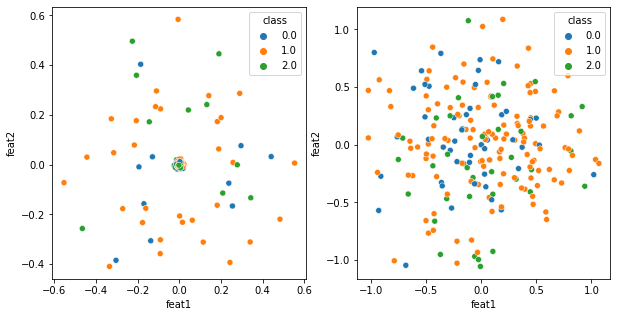

In [ ]:
n_components = 2
pipe_pca = make_pipeline(MinMaxScaler(), PCA(n_components=n_components))   
X_pca = pipe_pca.fit(X_diff).transform(X_diff)
display(pipe_pca[1].explained_variance_ratio_)
X_pca_class = pipe_pca.fit(X_class).transform(X_class)
display(pipe_pca[1].explained_variance_ratio_)

set_fig_size((10, 5))
fig, ax = plt.subplots(1,2)
plot_dim_reduction(X_pca, y_class, ax = ax[0])
plot_dim_reduction(X_pca_class, y_class, ax = ax[1])

##### LDA

No x = 0 (feat1) parece ser possível fazer a divisão entre os dois estados (0 e 2), perceber como é que esta feat é constuída (pode dar infornação sobre feat original mais importante)

Class 0 in 0:  330372
Class 1 in 0:  8743
Class 0 in 1:  8062
Class 1 in 1:  66507


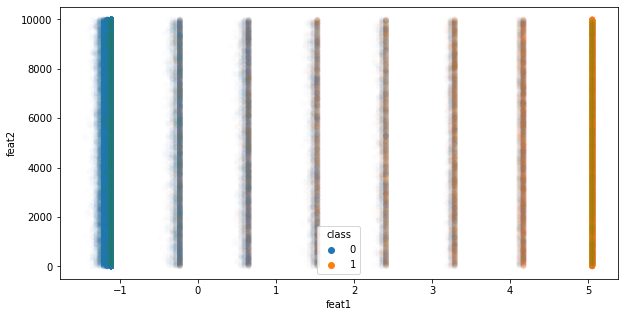

In [ ]:
features = [f"var1(t-{i})_states" for i in range(1, n_past_days+1)]
features = ["down_count", "same_count", "up_count", "missing_count"]
X = df_pred_mv[features]
y = df_pred_mv["states_binary"]

pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components = 1))
X_lda = pipe_lda.fit(X, y).transform(X)
set_fig_size((10, 5))
plot_dim_reduction(X_lda, y, None, title = None)

X_lda = X_lda.reshape((len(X_lda),))
y_flt_0 = y[X_lda < 2]
y_flt_1 = y[X_lda > 2]
print("Class 0 in 0: ", len(y_flt_0[y_flt_0 == 0]))
print("Class 1 in 0: ", len(y_flt_0[y_flt_0 == 1]))
print("Class 0 in 1: ", len(y_flt_1[y_flt_1 == 0]))
print("Class 1 in 1: ", len(y_flt_1[y_flt_1 == 1]))

(3, 6)


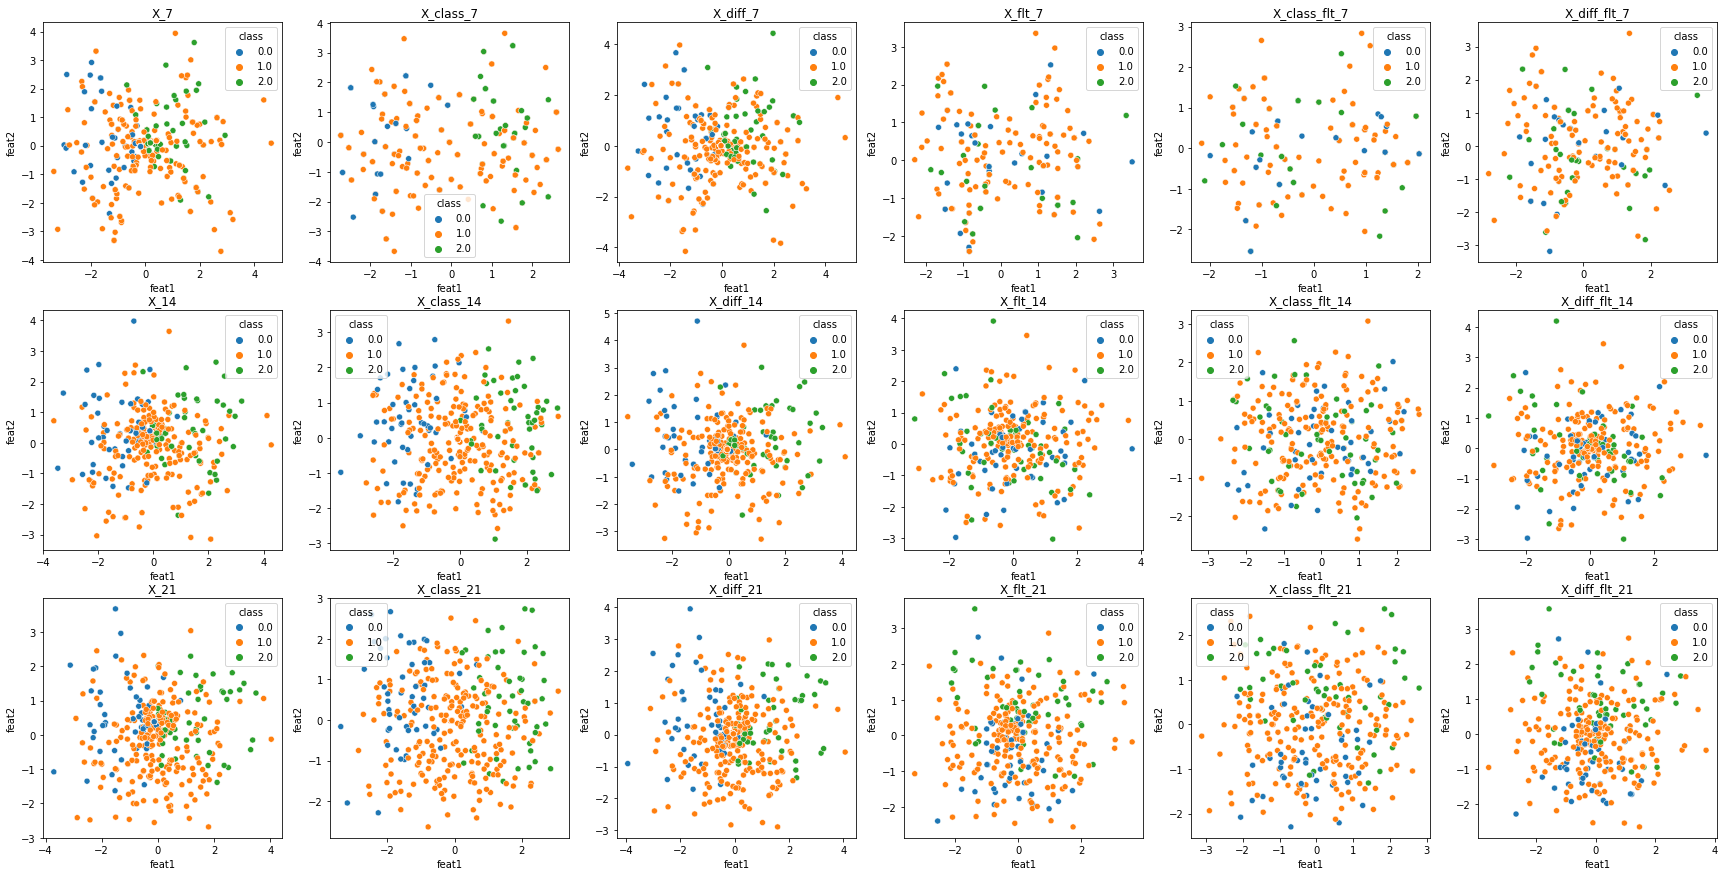

In [ ]:
lda_results_all_lags = []
n_lags = len(data_lags)
n_X = len(data_lags[0][0])
set_fig_size((5*n_X, 5*n_lags))
fig, ax = plt.subplots(n_lags, n_X)

for data_lag in data_lags:
  lda_results = []
  X_group = data_lag[0]
  y_group = data_lag[1]
  for X, y, i in zip(X_group, y_group, range(len(X_group))):
    pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components = 2))
    X_lda = pipe_lda.fit(X, y).transform(X)
    lda_results.append([pipe_lda, X_lda, y])
  lda_results_all_lags.append(lda_results)

titles = ["X_", "X_class_", "X_diff_", "X_flt_", "X_class_flt_", "X_diff_flt_"]
titles_lags = []
for lags in lags_list:
  titles_lags.append([sub + str(lags) for sub in titles])

print(ax.shape)
for j in range(ax.shape[0]):
  for i in range(ax.shape[1]):
    pipe_lda, X_lda, y = lda_results_all_lags[j][i]
    plot_dim_reduction(X_lda, y, ax = ax[j, i], title = titles_lags[j][i])

(3, 6)


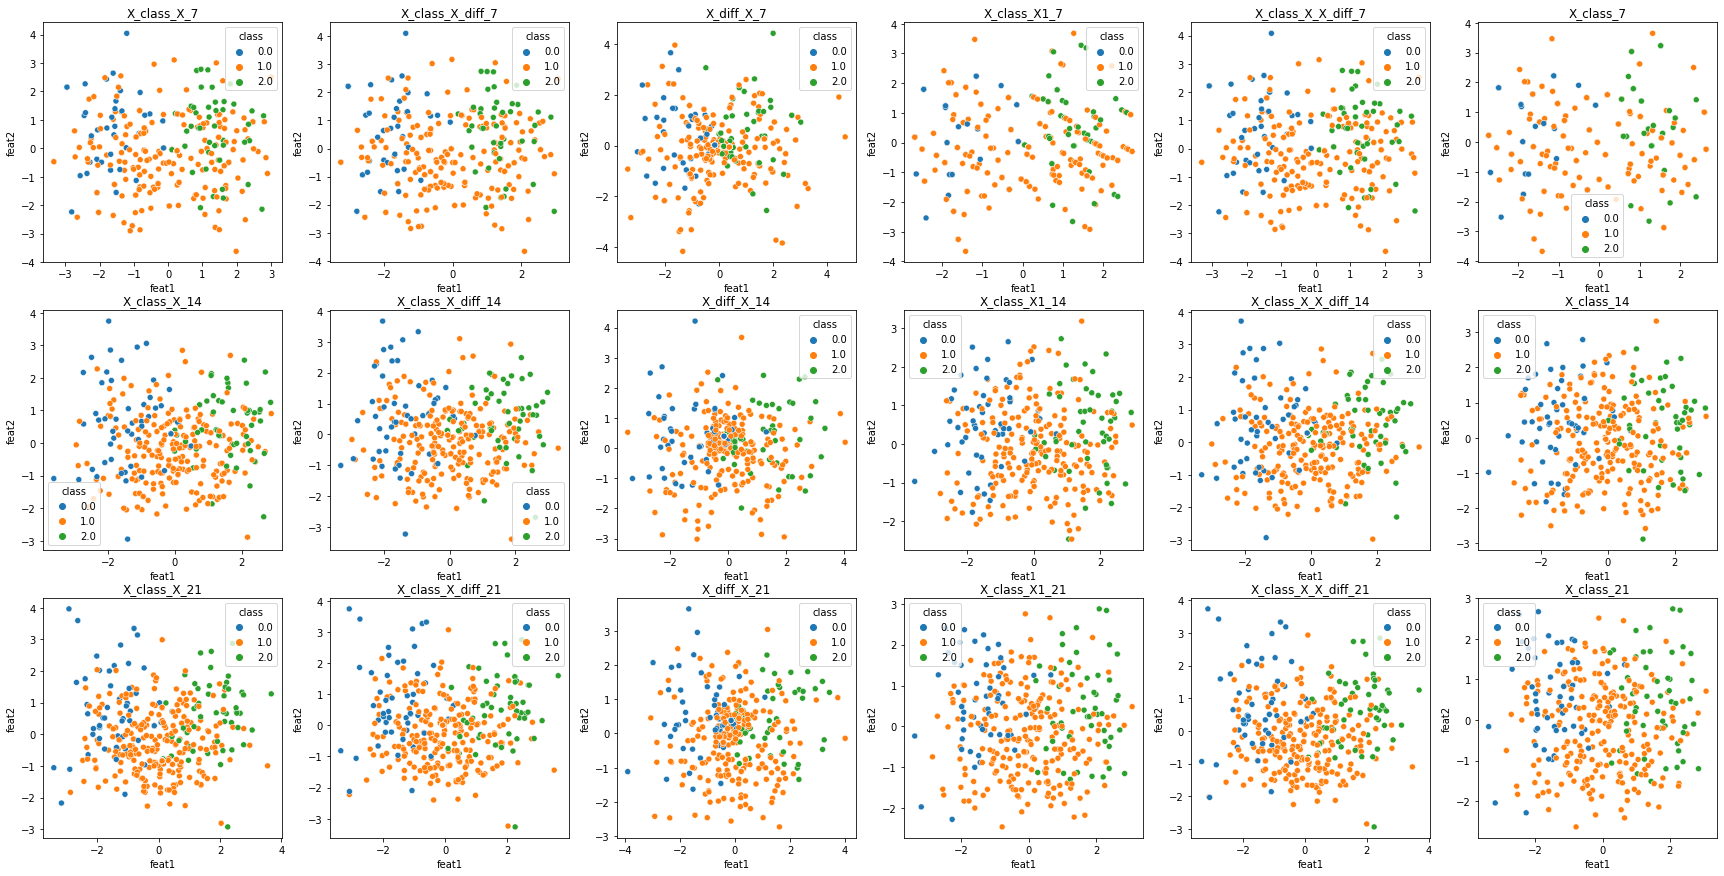

In [ ]:
X_group_concat_lags = []
y_group_concat_lags = []

for data_lag in data_lags:
  X_group = data_lag[0]
  y_group = data_lag[1]
  X = X_group[0]
  X_class = X_group[1]
  X_diff = X_group[2]
  y_class = y_group[1]
  
  X_group_concat = [pd.concat([X_class, X], axis = 1),
                    pd.concat([X_class, X_diff], axis = 1),
                    pd.concat([X_diff, X], axis = 1),
                    pd.concat([X_class, X["var1(t-1)"]], axis = 1),
                    pd.concat([X_class, X, X_diff], axis = 1),
                    X_class]
  y_group_concat = [y_class] * len(X_group_concat)

  X_group_concat_lags.append(X_group_concat)
  y_group_concat_lags.append(y_group_concat)


lda_results_all_lags = []
n_lags = len(X_group_concat_lags)
n_X = len(X_group_concat_lags[0])
set_fig_size((5*n_X, 5*n_lags))
fig, ax = plt.subplots(n_lags, n_X)

for X_group_concat_lag, y_group_concat_lag in zip(X_group_concat_lags, y_group_concat_lags):
  
  lda_results = []

  for X, y, i in zip(X_group_concat_lag, y_group_concat_lag, range(len(X_group_concat_lag))):
    pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components = 2))
    X_lda = pipe_lda.fit(X, y).transform(X)
    lda_results.append([pipe_lda, X_lda, y])
  lda_results_all_lags.append(lda_results)

titles = ["X_class_X_", "X_class_X_diff_", "X_diff_X_", "X_class_X1_", "X_class_X_X_diff_", "X_class_"]
titles_lags = []
for lags in lags_list:
  titles_lags.append([sub + str(lags) for sub in titles])

print(ax.shape)
for j in range(ax.shape[0]):
  for i in range(ax.shape[1]):
    pipe_lda, X_lda, y = lda_results_all_lags[j][i]
    plot_dim_reduction(X_lda, y, ax = ax[j, i], title = titles_lags[j][i])

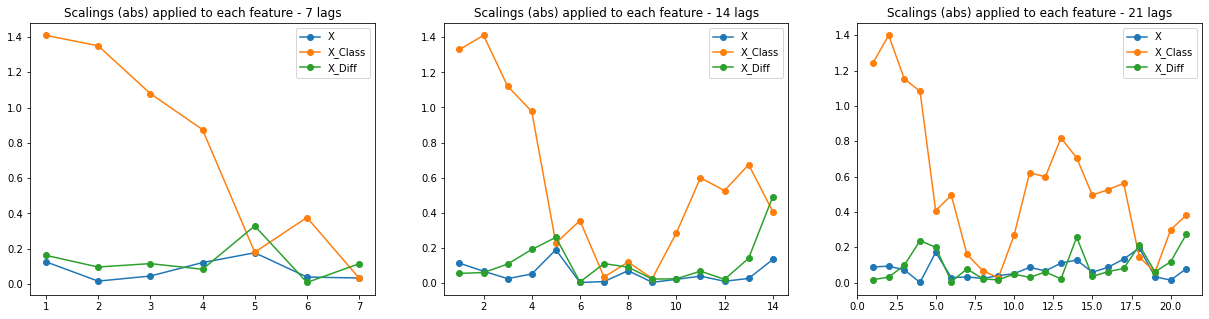

In [ ]:
scales_lags = []

for data_lag in data_lags:
  X_group = data_lag[0]
  y_group = data_lag[1]
  X = pd.concat(X_group[0:3], axis = 1)
  y = y_group[1]
  pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components = 2))
  X_lda = pipe_lda.fit(X, y).transform(X)
  scales = pipe_lda.named_steps["lineardiscriminantanalysis"].scalings_
  scales_lags.append(scales)

n_scales = len(scales_lags)
set_fig_size((7*n_scales, 5))
fig, ax = plt.subplots(1, n_scales)
for scales, axes, lags in zip(scales_lags, ax, lags_list):
  axes.plot(list(range(lags,0,-1)), abs(scales[:lags,0]), list(range(lags,0,-1)), abs(scales[lags:2*lags,0]), list(range(lags,0,-1)), abs(scales[2*lags:,0]), marker='o')
  axes.legend(["X", "X_Class", "X_Diff"])
  axes.set_title("Scalings (abs) applied to each feature - " + str(lags) + " lags")

(3, 6)


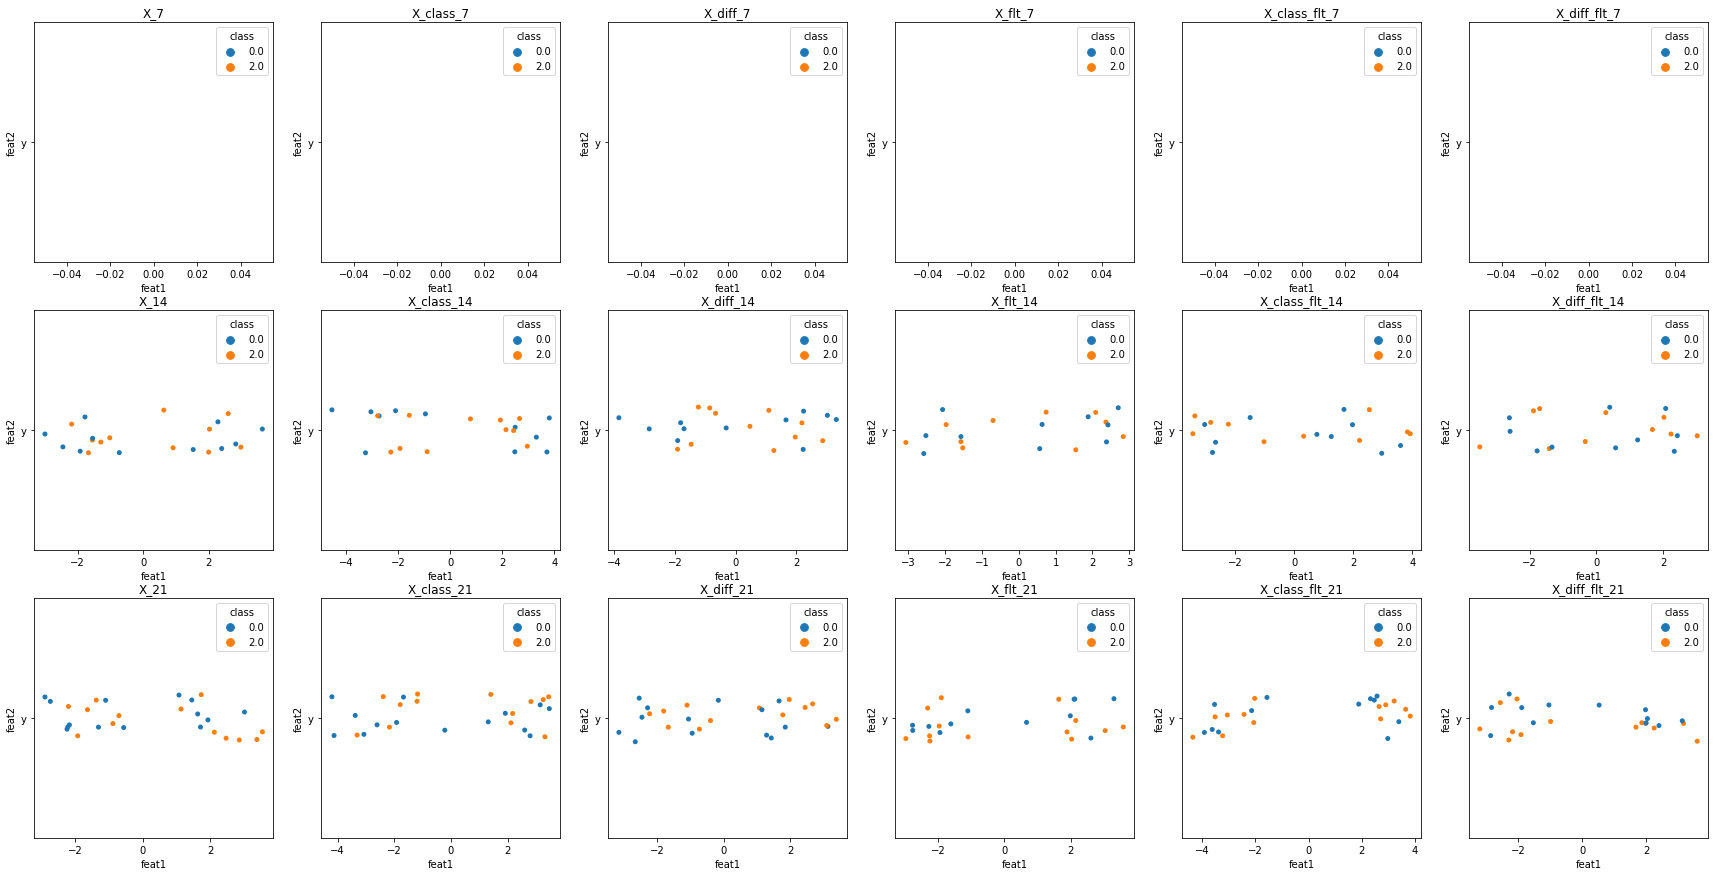

In [ ]:
lda_results_all_lags = []
n_lags = len(data_lags)
n_X = len(data_lags[0][0])
set_fig_size((5*n_X, 5*n_lags))
fig, ax = plt.subplots(n_lags, n_X)

for data_lag in data_lags:
  lda_results = []
  X_group = data_lag[0]
  y_group = data_lag[1]
  for X, y, i in zip(X_group, y_group, range(len(X_group))):
    condition = ((y == 0) | (y == 2))
    X = X[condition]
    y = y[condition]
    pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
    X_lda = pipe_lda.fit(X, y).transform(X)
    lda_results.append([pipe_lda, X_lda, y])
  lda_results_all_lags.append(lda_results)

titles = ["X_", "X_class_", "X_diff_", "X_flt_", "X_class_flt_", "X_diff_flt_"]
titles_lags = []
for lags in lags_list:
  titles_lags.append([sub + str(lags) for sub in titles])

print(ax.shape)
for j in range(ax.shape[0]):
  for i in range(ax.shape[1]):
    pipe_lda, X_lda, y = lda_results_all_lags[j][i]
    plot_dim_reduction(X_lda, y, ax = ax[j, i], title = titles_lags[j][i])

##### Random Forest

Nem todas as séries parecem exibir dependência semanal. Algumas têm, tipo a primeira, mas outras não têm. Não é possível extrair uma regra fiável para todas elas. Mas mostra-se que há alguma dependência temporal. Podia ser útil usar esta informação em marketing??

In [ ]:
def plot_feature_importance(rf, features_name_list, title = None, ax = None):
  feature_imp = pd.Series(rf.feature_importances_, index = range(len(rf.feature_importances_), 0, -1))#.sort_values(ascending=False)
  #print('Feature importances: ', rf.feature_importances_)
  sns.barplot(x=feature_imp.index, y=feature_imp, ax = ax)
  if ax == None:
    plt.xlabel('Feature Importance Score', fontsize=8)
    plt.ylabel('Features', fontsize=8)
    plt.title(title, fontsize=10, pad=10)
  else:
    ax.set_xlabel('Feature Importance Score', fontsize=8)
    ax.set_ylabel('Features', fontsize=8)
    ax.set_title(title, fontsize=10, pad=10)

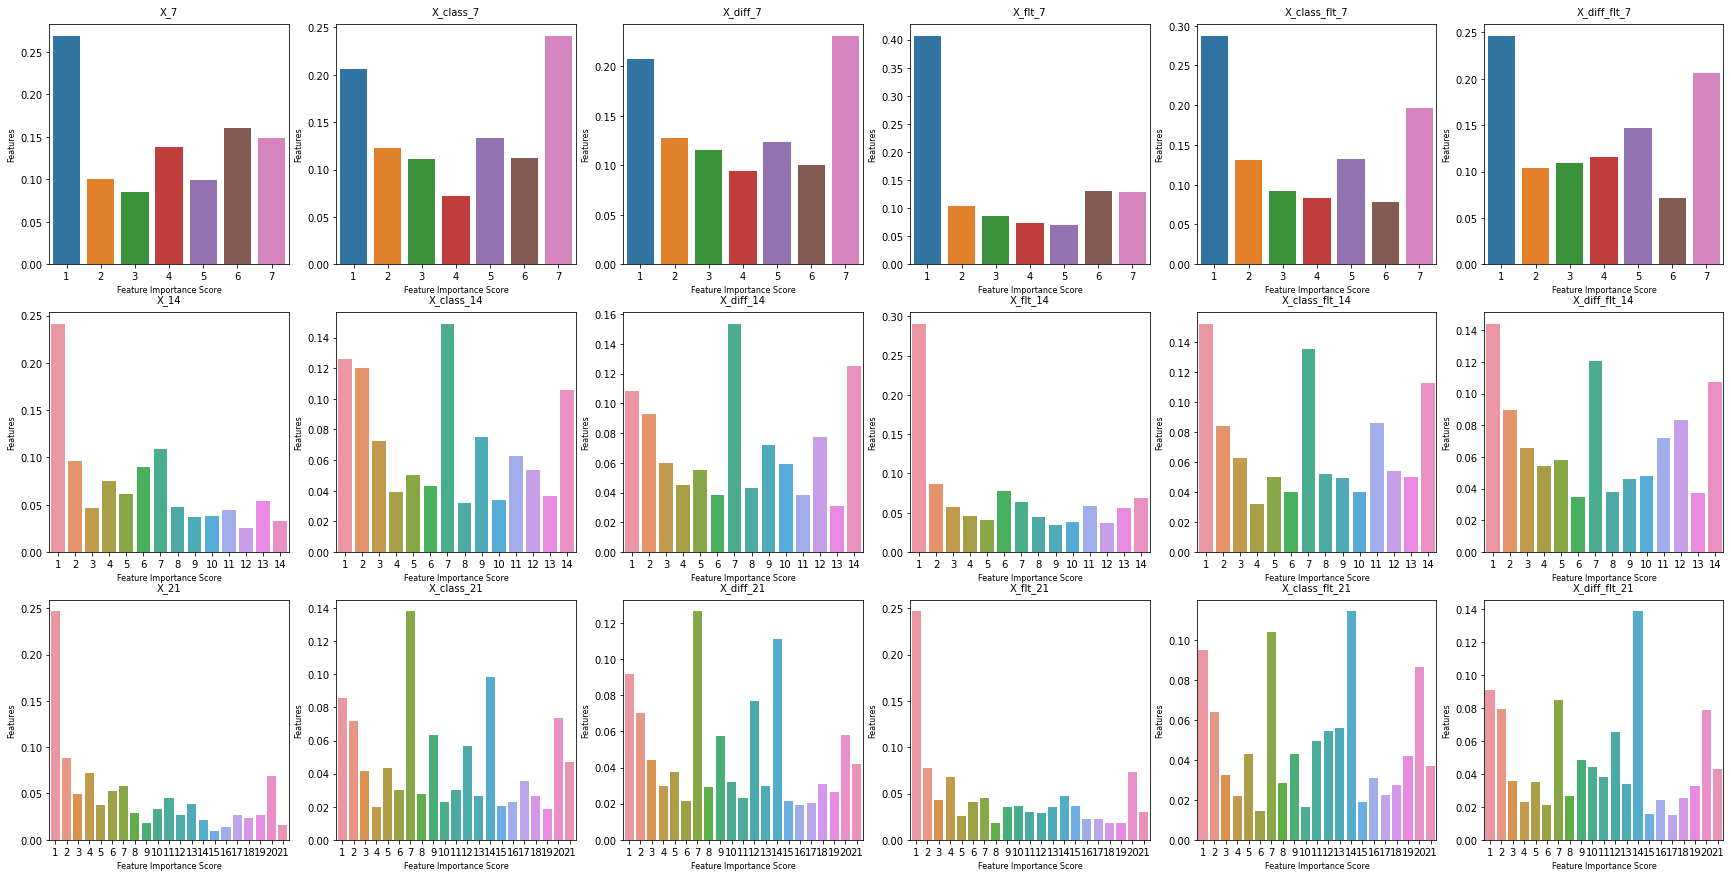

In [ ]:
rf_class_all_lags = []
n_lags = len(data_lags)
n_X = len(data_lags[0][0])
set_fig_size((5*n_X, 5*n_lags))
fig, ax = plt.subplots(n_lags, n_X)

for data_lag in data_lags:
  rf_class = []
  X_group = data_lag[0]
  y_group = data_lag[1]
  for X, y, i in zip(X_group, y_group, range(len(X_group))):
    rf = RandomForestClassifier(n_estimators=100, max_depth=3, bootstrap=True, n_jobs=-1, random_state=0)
    rf.fit(X, y)
    rf_class.append([rf, X])
  rf_class_all_lags.append(rf_class)

titles = ["X_", "X_class_", "X_diff_", "X_flt_", "X_class_flt_", "X_diff_flt_"]
titles_lags = []
for lags in lags_list:
  titles_lags.append([sub + str(lags) for sub in titles])

for j in range(ax.shape[0]):
  for i in range(ax.shape[1]):
    rf, X = rf_class_all_lags[j][i]
    plot_feature_importance(rf, X.columns, title = titles_lags[j][i], ax = ax[j, i])

##### T-SNE

Depois de experimentar várias combinações de parâmetros, nenhum deles pareceu retornar nenhum resultado interessante.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


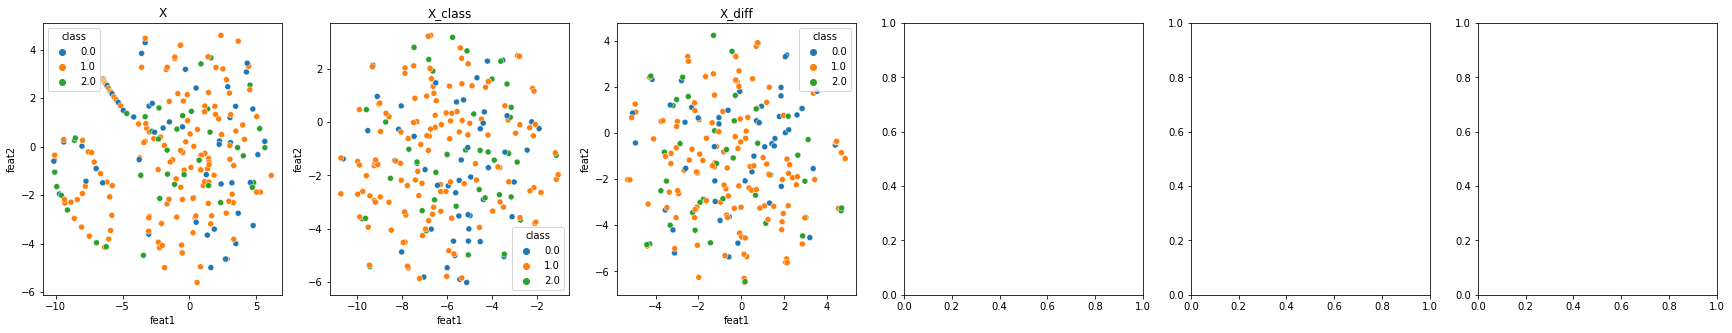

In [ ]:
from sklearn.manifold import TSNE

pipe_tsne = make_pipeline(MinMaxScaler(), TSNE(learning_rate = 300, perplexity = 50))
X_lda = pipe_tsne.fit_transform(X)
X_lda_class = pipe_tsne.fit_transform(X_class)
#X_lda_diff = pipe_tsne.fit_transform(X_diff)
#X_lda_flt = pipe_tsne.fit_transform(X_flt)
#X_lda_class_flt = pipe_tsne.fit_transform(X_class_flt)
#X_lda_diff_flt = pipe_tsne.fit_transform(X_diff_flt)

set_fig_size((30, 5))
fig, ax = plt.subplots(1,6)
plot_dim_reduction(X_lda, y_class, ax = ax[0], title = "X")
plot_dim_reduction(X_lda_class, y_class, ax = ax[1], title = "X_class")
plot_dim_reduction(X_lda_diff, y_class, ax = ax[2], title = "X_diff")
#plot_dim_reduction(X_lda_flt, y_class_flt, ax = ax[3], title = "X_flt")
#plot_dim_reduction(X_lda_class_flt, y_class_flt, ax = ax[4], title = "X_class_flt")
#plot_dim_reduction(X_lda_diff_flt, y_class_flt, ax = ax[5], title = "X_diff_flt")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Class')

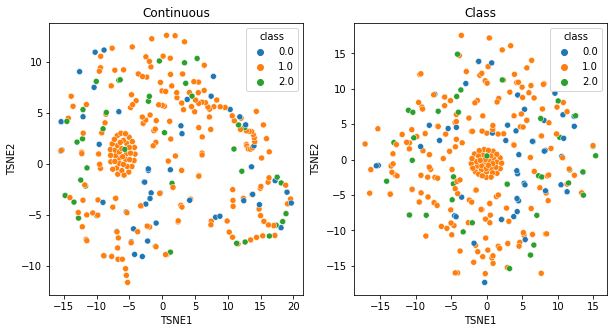

In [ ]:
from sklearn.manifold import TSNE

# Apply
pipe_tsne = make_pipeline(MinMaxScaler(), TSNE())
X_tsne = pipe_tsne.fit_transform(X)
X_tsne_class = pipe_tsne.fit_transform(X_class)

# Concatenate LDA results with class information
data = pd.concat([pd.DataFrame(X_tsne), pd.DataFrame(y_class)], axis = 1)
data_class = pd.concat([pd.DataFrame(X_tsne_class), pd.DataFrame(y_class)], axis = 1)
data.columns = ["TSNE1", "TSNE2", "class"]
data_class.columns = ["TSNE1", "TSNE2", "class"]
data["class"] = data["class"].astype("category")
data_class["class"] = data_class["class"].astype("category")

# Plot
set_fig_size((10, 5))
fig, ax = plt.subplots(1,2)
h = sns.scatterplot(data = data, x = "TSNE1", y = "TSNE2", hue = "class", ax = ax[0])
h.set_title("Continuous")
h = sns.scatterplot(data = data_class, x = "TSNE1", y = "TSNE2", hue = "class", ax = ax[1])
h.set_title("Class")

##### Kernel PCA

Text(0.5, 1.0, 'Class')

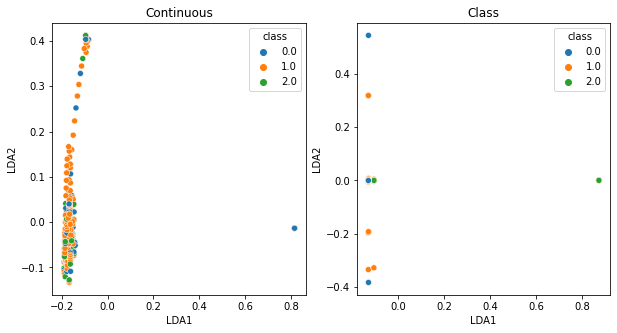

In [ ]:
from sklearn.decomposition import KernelPCA

# Apply LDA
pipe_lda = make_pipeline(MinMaxScaler(), KernelPCA(n_components=2, kernel='rbf', gamma=15, random_state=42))
X_lda = pipe_lda.fit(X).transform(X)
X_lda_class = pipe_lda.fit(X_class).transform(X_class)

# Concatenate LDA results with class information
data = pd.concat([pd.DataFrame(X_lda), pd.DataFrame(y_class)], axis = 1)
data_class = pd.concat([pd.DataFrame(X_lda_class), pd.DataFrame(y_class)], axis = 1)
data.columns = ["LDA1", "LDA2", "class"]
data_class.columns = ["LDA1", "LDA2", "class"]
data["class"] = data["class"].astype("category")
data_class["class"] = data_class["class"].astype("category")

# Plot
set_fig_size((10, 5))
fig, ax = plt.subplots(1,2)
h = sns.scatterplot(data = data, x = "LDA1", y = "LDA2", hue = "class", ax = ax[0])
h.set_title("Continuous")
h = sns.scatterplot(data = data_class, x = "LDA1", y = "LDA2", hue = "class", ax = ax[1])
h.set_title("Class")

###### Predict duration of missing value

In [ ]:
df_prepared = df_prepared.groupby(by = "product_id").apply(find_local_max)
df_prepared_filter = df_prepared[(~df_prepared["max"].isna())].reset_index().set_index("product_id")[["days_out_of_stock", "timestamp"]]

In [ ]:
df_num = df_prepared_filter.groupby("product_id").count()
product_id_lst = df_num.sort_values(by = "days_out_of_stock", ascending = False).index

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


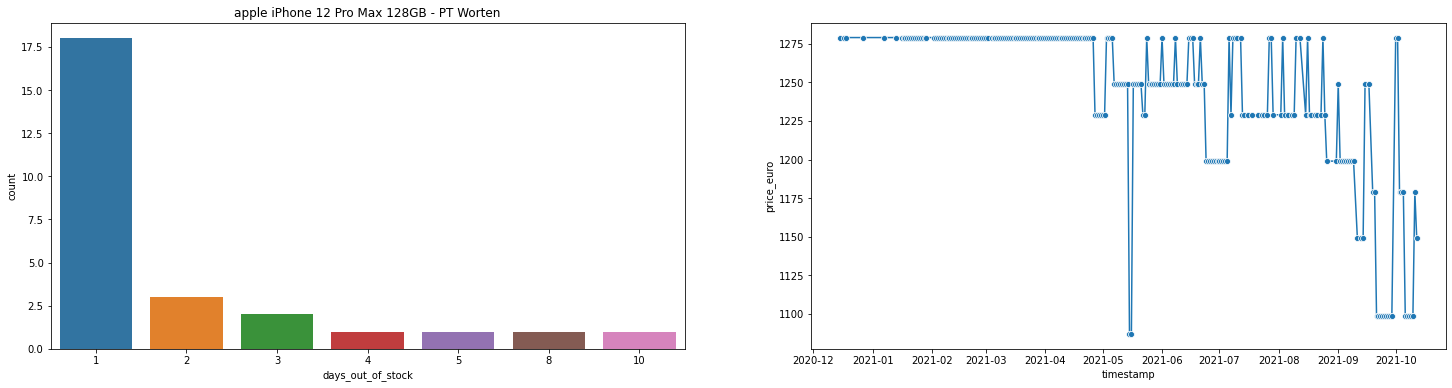

In [ ]:
new_index = df[["product_id", "product", "country_company"]].set_index("product_id").drop_duplicates()
df_prepared_filter_w_index = df_prepared_filter.join(new_index, how = "inner")

set_fig_size((25,6))
product_id = product_id_lst[20]

fig, ax = plt.subplots(1,2)
p = sns.countplot(df_prepared_filter_w_index.loc[product_id].days_out_of_stock, ax = ax[0])
p.set_title(df_prepared_filter_w_index.loc[product_id]["product"].iloc[0] + " - " + df_prepared_filter_w_index.loc[product_id]["country_company"].iloc[0])
sns.lineplot(data = df[df["product_id"] == product_id], x = "timestamp", y = "price_euro", marker = 'o', ax = ax[1])

In [ ]:
new_index = df[["product_id", "country_company"]].drop_duplicates().set_index("product_id")
df_prepared_filter_companies = pd.merge(df_prepared_filter, new_index, left_index=True, right_index=True).reset_index()[["product_id", "days_out_of_stock",	"country_company"]]
df_prepared_filter_companies

,product_id,days_out_of_stock,country_company
0,1,1,CL Falabella
1,1,18,CL Falabella
2,2,1,CO Movistar
3,2,2,CO Movistar
4,2,1,CO Movistar
...,...,...,...
10058,3233,14,PE Claro
10059,3233,17,PE Claro
10060,3233,8,PE Claro
10061,3234,1,CO Claro


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


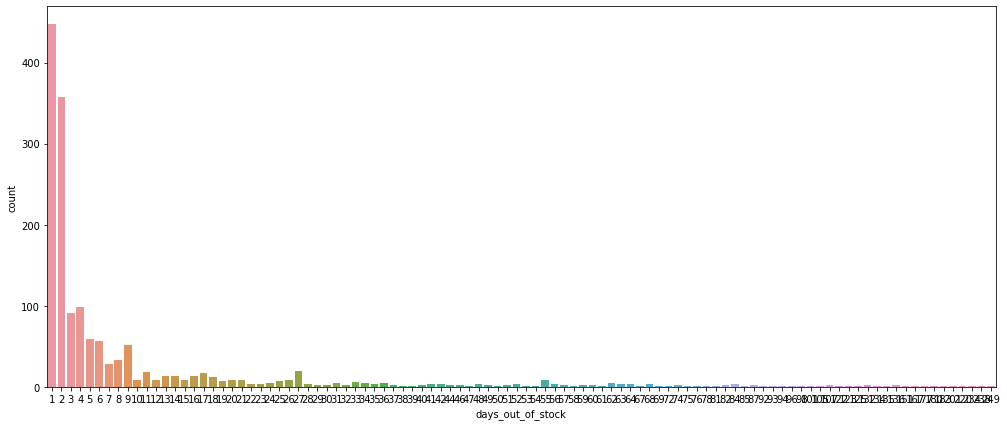

In [ ]:
country_company_lst = df_prepared_filter_companies.country_company.unique()
a = df_prepared_filter_companies[df_prepared_filter_companies.country_company == country_company_lst[4]].days_out_of_stock
set_fig_size((17, 7))
sns.countplot(a)

###### Check if missing values are more common near ups or downs or sames (não sei quão útil será isto)

In [ ]:
results = pd.read_pickle("markov_fill_w_na.pkl").dropna()[["n_changes", "n_samples", "data", "obs", "is_like_baseline", "transition_matrix"]]

In [ ]:
def transform_2_features(df, lags, value, id):
  df = df.groupby(id)[value].apply(series_to_supervised, **{"n_in" : lags})
  df_lags = df.groupby(id).apply(convert_2_states_df).add_suffix("_class")
  df_diff = df.groupby(id).diff().add_suffix("_diff")
  return pd.concat([df, df_lags, df_diff], axis = 1)

In [ ]:
def get_missing_values_info(df, n_past_days = 14, min_num = 6):
  df = df.copy()
  df = df.states.loc[((df.states.shift() != df.states) & (df.states == 3)) | (df.states != 3)]
  df = series_to_supervised(df, n_in = n_past_days, n_out=1, dropnan = True)
  df = df[df["var1(t)"] == 3]
  features = [f"var1(t-{i})" for i in range(1, n_past_days+1)]
  df["down_count"]    = df[features].apply(lambda x: sum(x==0), axis=1)
  df["up_count"]      = df[features].apply(lambda x: sum(x==2), axis=1)
  df["missing_count"] = df[features].apply(lambda x: sum(x==3), axis=1)
  df["changes_count"] = df[features].apply(lambda x: sum(x==0) + sum(x==2), axis=1)
  return df["down_count"].sum(), df["up_count"].sum(), df["missing_count"].sum(), df["down_count"].mean(), df["up_count"].mean(), df["missing_count"].mean(), df["changes_count"], (len(df) > min_num)

i = 2
n_past_days = 7
id = "product_id"
value = "states"

test_obs = results.obs
test_obs_processed = test_obs.apply(get_missing_values_info)
#test_obs_processed = get_missing_values_info(test_obs)

columns = ("down_count", "up_count", "missing_count", "down_count_mean", "up_count_mean", "missing_count_mean", "changes_count", "more_than_min")
test_obs_processed = pd.DataFrame([[a,b,c,d,e,f,g,h] for a,b,c,d,e,f,g,h in test_obs_processed.values], columns=columns, index = test_obs_processed.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

##### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2)
pca.fit(df_weekdays)
#pca_df_weekdays = pca.
PCA(n_components=2)
pca.n_components

2

In [ ]:
# Pre-processing
df_weekdays_scaled = MinMaxScaler().fit_transform(df_weekdays)

# PCA
n_components = 2
pca = PCA(n_components=n_components).fit(df_weekdays_scaled)
print(pca.explained_variance_ratio_)

# Apply PCA
weekdays_scaled_pca = pca.transform(df_weekdays_scaled)

[0.65406889 0.10597539]


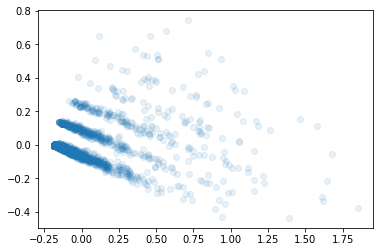

In [ ]:
plt.scatter(weekdays_scaled_pca[:,0], weekdays_scaled_pca[:,1], alpha = 0.1)

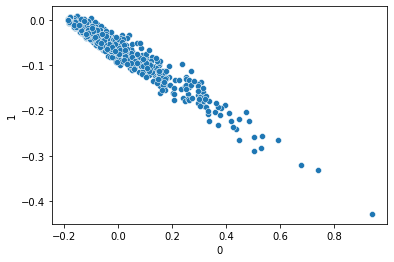

In [ ]:
df_weekdays_scaled_pca = pd.DataFrame(weekdays_scaled_pca)
df_weekdays_scaled_pca = df_weekdays_scaled_pca.set_index(df_weekdays.index)
df_weekdays_scaled_pca = df_weekdays_scaled_pca[df_weekdays_scaled_pca[1] < -0.5*df_weekdays_scaled_pca[0]+ 0.05]

sns.scatterplot(data = df_weekdays_scaled_pca, x = 0, y = 1)

<BarContainer object of 7 artists>

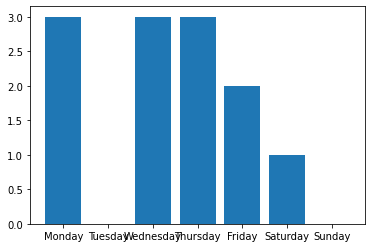

In [ ]:
list_product_id = df_weekdays_scaled_pca.index
df_weekdays.iloc[list_product_id[0]]
#df_weekdays_select = df_weekdays[df_weekdays.index.isin([list_product_id[0]])]
plt.bar(df_weekdays.iloc[list_product_id[0]].index, df_weekdays.iloc[list_product_id[7]])

Plano para a semana:

- vamos tentar fechar rapidamente a parte dos modelos univariados
  - acredita-se que eles não contenham informação suficiente para serem proactivos, isto é, apenas conseguem ser reactivos. Isto signfiica que não hão de conseguir prever saltos, apenas conseguem reagir a eles.
  - os modelos ARIMA e REPEAT são meramente reactivos. O ARIMA aqui nunca funcionaria bem como proactivo porque há longos períodos dos dados em que não há mudanças. O máximo que se pode fazer com estes modelos é fazer com que o ARIMA tenha uma melhor performance que os REPEAT porque há modelos para os quais seguir os dados (REPEAT) funciona melhor, mas há outros em que a melhor abordagem é ser um filtro passa baixo, mais indiferente às mudanças. Como o ARIMA também contém de certa forma o modelo REPEAT (1º lag do AR), pode ser visto como uma extensão deste.
  - pode ter que se mudar a forma como se faz a criação dos modelos ARIMA - pode-se começar por treinar os modelos com todos os coeficientes (até 14 lags - para conter as alterações semanais de pelo menos uma semana inteira, já que já se verificou que existe alguma dependência nesse sentido) e ver quais os coeficientes cujo intervalo de confiança está a zero e eliminar esses coeficientes - a ideia é fazer duas vezes refit 
  - cadeias de Markov podem eventualmente ser proactivas (??) - modelo não linear - pode usar informação da semana - maybe - pensar mais sobre isto
  - podemos rapidamente tentar correr redes neuronais e mostrar que não há grandes aumentos da performance - apesar de estas redes contarem com efeitos não lineares - estas redes terão que ser comparadas com os modelos ARIMA que contém todos os lags
  - analisar melhor a dependência com os dias da semana - para fazer cluster a professora sugeriu usar dendogramas - calcular a distância de cada distribuição a cada distribuição e ver quais são as mais próximas 
    dendrograma - distância do tipo L2 de cada série a cada série
    distâncias para distribuições discretas

O problema destas séries temporais e do uso de modelos univariados é que as células têm muito poucas amostras, o que signfica que se torna difícil encontrar tendências ao longo dos dados. Para além disso, os preços dos produtos estão altamente condicionados por decisões humanas (e.g. realização de campanhas para baixa de preços) que, por sua vez, estão a reagir a movimentos aos quais não temos acesso. Tendo isso em conta, e assumindo que nalgumas séries temporais as mudanças são aleatórias, torna-se difícil fazer previsões. O que podemos esperar e ambicionar é que as mudanças que ocorrem nalgumas séries influenciem diretamente o que acontece noutras e a previsão de mudanças para de ser completamente aleatória. 

Mas seria muito útil obter o máximo de informação possível contida numa série apenas - ver dependência semanal, mensal se der...
Procurar vários métodos para analisar essa dependência temporal, isto é, sem usar apenas métodos lineares.

Depois disto tudo poderemos eventualmente avançar para métodos multi variados. 
